In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import deepcopy
from dataclasses import dataclass
from typing import List
from collections import defaultdict
from statsmodels.stats.anova import anova_lm

from qscaled.utils.configs import BaseConfig
from qscaled.utils.zip_handler import fetch_zip_data
from qscaled.core.preprocessing import bootstrap_crossings, filter_out_resets

from scripts.zip_handler import ModelSizeZipHandler
from scripts.collector import BROModelScalingCollector
from scripts.core.preprocess import (
    bootstrap_crossings_per_env,
    compute_thresholds_per_env,
    truncate,
    remove_incomplete,
    filter_out_resets,
    manual_metrics,
)
from scripts.utils import abbreviate_number
from scripts.experiments.targets.plot_utils import plot_metric_over_training_3d_multiple_metrics
from scripts.generate_runs.constants import DEFAULT_MAX_STEPS


import qscaled

qscaled.constants.suppress_overwrite_prompt = True

In [4]:
main_collector = BROModelScalingCollector(
    'anonymous',
    'BRO_model_scaling',
    wandb_tags=['separate_critic_250424', 'separate_critic_250503'],
    use_cached=True,
)
main_collector.remove_short()
collector = main_collector.filter('learning_rate==3e-4 and use_separate_critic==True').flatten()

In [5]:
@dataclass(kw_only=True)
class ModelSizeSweepConfig(BaseConfig):
    utds_to_predict: List[float]  # UTDs to predict hyperparams for
    model_sizes_to_predict: List[int]


config_input_dict = dict(
    max_returns={},
    returns_key='return',
    utds_to_predict=[0.25, 0.5, 1, 2, 4, 8, 16, 32],
    model_sizes_to_predict=[128, 256, 512, 1024, 2048, 4096],
    thresholds=[],  # placeholder
)

config = ModelSizeSweepConfig(
    name='side_critic',  # Zip filename
    wandb_collector=collector,
    zip_handler_cls=ModelSizeZipHandler,
    **config_input_dict,
)

truncate_steps = DEFAULT_MAX_STEPS

In [6]:
# Fetch the data
df = fetch_zip_data(config, use_cached=True)
df = truncate(df, truncate_steps)

In [7]:
df = manual_metrics(df)

In [8]:
metric_dict = {
    'return': {},
    'critic_loss': {},
    'validation_critic_loss': {'alias': 'validation_loss'},
    'validation_overfitting': {},
    'new_data_critic_loss': {'alias': 'new_data_loss'},
    'new_data_overfitting': {},
    'old_data_critic_loss': {'alias': 'old_data_loss'},
    'old_data_overfitting': {},
    'old_target_critic_loss': {'alias': 'old_target_loss'},
    'mean_critic_grad_var': {'alias': 'critic_grad_var', 'yscale': 'log'},
    'adam_mean_critic_grad_var': {'alias': 'adam_critic_grad_var', 'yscale': 'log'},
    'critic_gnorm': {},
    'critic_pnorm': {},
}

xmin, xmax = 50000, 1e6

In [9]:
plot_kw = dict(
    row_group_name='critic_width',
    col_group_name='separate_critic_width',
    row_label_name='critic_params',
    col_label_name='separate_critic_params',
    title_fn=lambda c,
    s: f'$N$={abbreviate_number(c)}, $N_{{\\text{{side}}}}$={abbreviate_number(s)}',
    xlim=(xmin, xmax),
)

      env_name  critic_width  separate_critic_width  summary_metric
0  h1-crawl-v0           512                    512       33.382157
1  h1-crawl-v0           512                   1024       21.817049
2  h1-crawl-v0           512                   2048       21.033574
3  h1-crawl-v0          1024                    512       14.223763
4  h1-crawl-v0          1024                   1024        7.744187
5  h1-crawl-v0          1024                   2048        9.476483
6  h1-crawl-v0          2048                    512       15.724325
7  h1-crawl-v0          2048                   1024       10.276201
8  h1-crawl-v0          2048                   2048        9.512952


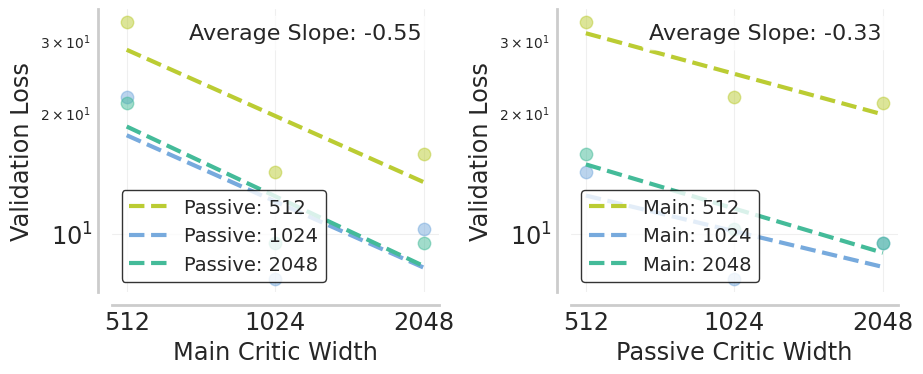

In [33]:
"""
anonymous: my rliable plot with three different lines
"""
import statsmodels.api as sm
# getting the data


# Helper function to calculate the summary metric for a single row
# Essentially take the mean of a row from start_step to end_step
def _calculate_summary_metric_for_row(
    row, training_step_col_name, metric_values_col_name, start_step, end_step
):
    try:
        steps = np.asarray(row[training_step_col_name])
        metric_values = np.asarray(row[metric_values_col_name])
    except Exception:
        return np.nan

    if steps.ndim == 0 or metric_values.ndim == 0 or steps.size == 0 or metric_values.size == 0:
        return np.nan

    if steps.size != metric_values.size:
        return np.nan

    mask = (steps >= start_step) & (steps <= end_step)
    relevant_metric_values = metric_values[mask]

    if relevant_metric_values.size > 0:
        return np.nanmean(relevant_metric_values)
    else:
        return np.nan


def get_data(og_df):
    df = og_df.copy()
    start_step_for_avg = 720000
    end_step_for_avg = 800000

    # Prepare data for both metrics
    all_data = []
    metric_col_name = 'mean_sep_validation_critic_loss'

    df_copy = df.copy()
    df_copy['summary_metric'] = df_copy.apply(
        lambda row: _calculate_summary_metric_for_row(
            row, 'training_step', metric_col_name, start_step_for_avg, end_step_for_avg
        ),
        axis=1,
    )
    # print(df_copy)
    # df_processed = df_copy.dropna(subset=['summary_metric'])
    df_processed = df_copy

    if df_processed.empty:
        print(
            f'Warning: No data found or processed for {metric_col_name} in the step range {start_step_for_avg}-{end_step_for_avg}.'
        )
        return

    identifying_cols = ['env_name', 'critic_width', 'separate_critic_width']
    df_plot_ready = df_processed.groupby(identifying_cols, as_index=False)['summary_metric'].mean()
    df_plot_ready['critic_width'] = pd.to_numeric(df_plot_ready['critic_width'])
    df_plot_ready['separate_critic_width'] = pd.to_numeric(df_plot_ready['separate_critic_width'])

    return df_plot_ready


# getting the data
env_df = df.query('env_name == "h1-crawl-v0"')
data = get_data(env_df)
print(data)

# colors
from rliable import plot_utils

COLORS = [
    '#BBCC33',
    '#77AADD',
    '#44BB99',
    '#EEDD88',
    '#EE8866',
    '#FFAABB',
    '#99DDFF',
    '#44BB99',
    '#AAAA00',
    '#DDDDDD',
]
palette = sns.set_palette(COLORS)
plt.rcParams['text.usetex'] = False  # Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = (
    r'\usepackage{sansmath} \sansmath'  # Force sans-serif math mode (for axes labels)
)
plt.rcParams['font.family'] = 'sans-serif'  # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue']  # Choose a nice font here
sns.set_style('whitegrid')

from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('custom_gradient', [COLORS[0], COLORS[1]])
n_colors = 3
colors = [cmap(i / (n_colors - 1)) for i in range(n_colors)]

# plotting
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(896.0 / 192 * 2, 369.6 / 192 * 2)

all_critic_widths = sorted(data['critic_width'].unique())
all_separate_critic_widths = sorted(data['separate_critic_width'].unique())

# ax[0] stuff
# x-axis is the main critic width
for i, separate_critic_width in enumerate(all_separate_critic_widths):
    x_values = []
    y_values = []

    for j, critic_width in enumerate(all_critic_widths):
        value = data[
            (data['critic_width'] == critic_width)
            & (data['separate_critic_width'] == separate_critic_width)
        ]['summary_metric'].values[0]
        axes[0].scatter(critic_width, value, marker='o', color=COLORS[i], alpha=0.5, s=80)
        x_values.append(critic_width)
        y_values.append(value)

    # ax[0] plot the fitted line
    smooth_x = np.log(x_values)
    smooth_y = np.log(y_values)
    linear_fit = sm.OLS(smooth_y, sm.add_constant(smooth_x)).fit()
    y_fit = linear_fit.predict(sm.add_constant(smooth_x))
    axes[0].plot(
        np.exp(smooth_x),
        np.exp(y_fit),
        '--',
        color=COLORS[i],
        alpha=1.0,
        label=f'Passive: {separate_critic_width}',
        linewidth=3,
    )

axes[0].text(
    0.95,
    0.95,
    f'Average Slope: -0.55',
    transform=axes[0].transAxes,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
    fontsize=16,
)

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend(
    prop={'size': 14}, ncol=1, frameon=True, loc='lower left', facecolor='white', edgecolor='black'
)

x = np.logspace(np.log10(512), np.log10(2048), num=3)
x_ticks_labels = [f'{int(x)}' for x in x]
axes[0].xaxis.set_major_locator(plt.FixedLocator(x))
axes[0].xaxis.set_minor_locator(plt.NullLocator())
axes[0].set_xticks(x, x_ticks_labels)

# yticks = np.logspace(np.log10(7), np.log10(35), num=3)
# ylabels = ["%.0f" % (y) for y in yticks]
# ax.yaxis.set_major_locator(plt.FixedLocator(yticks))
# ax.yaxis.set_minor_locator(plt.NullLocator())
# ax.set_yticks(yticks, ylabels, size=14.5)

plot_utils._annotate_and_decorate_axis(
    axes[0],
    xlabel='Main Critic Width',
    ylabel='Validation Loss',
    labelsize='xx-large',
    ticklabelsize='xx-large',
    grid_alpha=0.3,
    legend=False,
)

# ax[1] stuff
for i, critic_width in enumerate(all_critic_widths):
    x_values = []
    y_values = []

    for j, separate_critic_width in enumerate(all_separate_critic_widths):
        value = data[
            (data['critic_width'] == critic_width)
            & (data['separate_critic_width'] == separate_critic_width)
        ]['summary_metric'].values[0]
        axes[1].scatter(separate_critic_width, value, marker='o', color=COLORS[i], alpha=0.5, s=80)
        x_values.append(separate_critic_width)
        y_values.append(value)

    # ax[1] plot the fitted line
    smooth_x = np.log(x_values)
    smooth_y = np.log(y_values)
    linear_fit = sm.OLS(smooth_y, sm.add_constant(smooth_x)).fit()
    y_fit = linear_fit.predict(sm.add_constant(smooth_x))
    axes[1].plot(
        np.exp(smooth_x),
        np.exp(y_fit),
        '--',
        color=COLORS[i],
        alpha=1.0,
        label=f'Main: {critic_width}',
        linewidth=3,
    )


axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend(
    prop={'size': 14}, ncol=1, frameon=True, loc='lower left', facecolor='white', edgecolor='black'
)
axes[1].text(
    0.95,
    0.95,
    f'Average Slope: -0.33',
    transform=axes[1].transAxes,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
    fontsize=16,
)

x = np.logspace(np.log10(512), np.log10(2048), num=3)
x_ticks_labels = [f'{int(x)}' for x in x]
axes[1].xaxis.set_major_locator(plt.FixedLocator(x))
axes[1].xaxis.set_minor_locator(plt.NullLocator())
axes[1].set_xticks(x, x_ticks_labels)

plot_utils._annotate_and_decorate_axis(
    axes[1],
    xlabel='Passive Critic Width',
    ylabel='Validation Loss',
    labelsize='xx-large',
    ticklabelsize='xx-large',
    grid_alpha=0.3,
    legend=False,
)

# plt.text(1.04, -0.14, '×1e4', transform=ax.transAxes,
#          horizontalalignment='right', verticalalignment='bottom',
#          fontsize='x-large', 'alpha=0.8)
# plt.text(-0.04, 0.93, '×1e7', transform=ax.transAxes,
#          horizontalalignment='right', verticalalignment='bottom',
#          fontsize='x-large', alpha=0.8)

plt.tight_layout()
plt.savefig('side_critic.pdf', dpi=300, bbox_inches='tight')

plt.show()

      env_name  critic_width  separate_critic_width  summary_metric
0  h1-crawl-v0           512                    512       33.382157
1  h1-crawl-v0           512                   1024       21.817049
2  h1-crawl-v0           512                   2048       21.033574
3  h1-crawl-v0          1024                    512       14.223763
4  h1-crawl-v0          1024                   1024        7.744187
5  h1-crawl-v0          1024                   2048        9.476483
6  h1-crawl-v0          2048                    512       15.724325
7  h1-crawl-v0          2048                   1024       10.276201
8  h1-crawl-v0          2048                   2048        9.512952


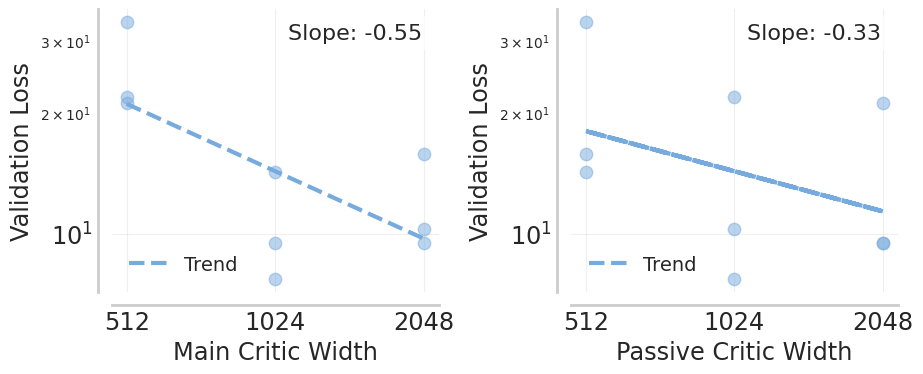

In [ ]:
"""
anonymous: my rliable plot attempt
"""
import statsmodels.api as sm
# getting the data


# Helper function to calculate the summary metric for a single row
# Essentially take the mean of a row from start_step to end_step
def _calculate_summary_metric_for_row(
    row, training_step_col_name, metric_values_col_name, start_step, end_step
):
    try:
        steps = np.asarray(row[training_step_col_name])
        metric_values = np.asarray(row[metric_values_col_name])
    except Exception:
        return np.nan

    if steps.ndim == 0 or metric_values.ndim == 0 or steps.size == 0 or metric_values.size == 0:
        return np.nan

    if steps.size != metric_values.size:
        return np.nan

    mask = (steps >= start_step) & (steps <= end_step)
    relevant_metric_values = metric_values[mask]

    if relevant_metric_values.size > 0:
        return np.nanmean(relevant_metric_values)
    else:
        return np.nan


def get_data(og_df):
    df = og_df.copy()
    start_step_for_avg = 720000
    end_step_for_avg = 800000

    # Prepare data for both metrics
    all_data = []
    metric_col_name = 'mean_sep_validation_critic_loss'

    df_copy = df.copy()
    df_copy['summary_metric'] = df_copy.apply(
        lambda row: _calculate_summary_metric_for_row(
            row, 'training_step', metric_col_name, start_step_for_avg, end_step_for_avg
        ),
        axis=1,
    )
    # print(df_copy)
    # df_processed = df_copy.dropna(subset=['summary_metric'])
    df_processed = df_copy

    if df_processed.empty:
        print(
            f'Warning: No data found or processed for {metric_col_name} in the step range {start_step_for_avg}-{end_step_for_avg}.'
        )
        return

    identifying_cols = ['env_name', 'critic_width', 'separate_critic_width']
    df_plot_ready = df_processed.groupby(identifying_cols, as_index=False)['summary_metric'].mean()
    df_plot_ready['critic_width'] = pd.to_numeric(df_plot_ready['critic_width'])
    df_plot_ready['separate_critic_width'] = pd.to_numeric(df_plot_ready['separate_critic_width'])

    return df_plot_ready


# getting the data
env_df = df.query('env_name == "h1-crawl-v0"')
data = get_data(env_df)
print(data)

# colors
from rliable import plot_utils

COLORS = [
    '#BBCC33',
    '#77AADD',
    '#44BB99',
    '#EEDD88',
    '#EE8866',
    '#FFAABB',
    '#99DDFF',
    '#44BB99',
    '#AAAA00',
    '#DDDDDD',
]
palette = sns.set_palette(COLORS)
plt.rcParams['text.usetex'] = False  # Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = (
    r'\usepackage{sansmath} \sansmath'  # Force sans-serif math mode (for axes labels)
)
plt.rcParams['font.family'] = 'sans-serif'  # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue']  # Choose a nice font here
sns.set_style('whitegrid')

from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('custom_gradient', [COLORS[0], COLORS[1]])
n_colors = 3
colors = [cmap(i / (n_colors - 1)) for i in range(n_colors)]

# plotting
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(896.0 / 192 * 2, 369.6 / 192 * 2)

all_critic_widths = sorted(data['critic_width'].unique())
all_separate_critic_widths = sorted(data['separate_critic_width'].unique())

# ax[0] stuff
x_values = []
y_values = []
for critic_width in all_critic_widths:
    for separate_critic_width in all_separate_critic_widths:
        value = data[
            (data['critic_width'] == critic_width)
            & (data['separate_critic_width'] == separate_critic_width)
        ]['summary_metric'].values[0]
        axes[0].scatter(critic_width, value, marker='o', color=COLORS[1], alpha=0.5, s=80)
        x_values.append(critic_width)
        y_values.append(value)

# ax[0] plot the fitted line
smooth_x = np.log(x_values)
smooth_y = np.log(y_values)
linear_fit = sm.OLS(smooth_y, sm.add_constant(smooth_x)).fit()
y_fit = linear_fit.predict(sm.add_constant(smooth_x))

axes[0].text(
    0.95,
    0.95,
    f'Slope: {linear_fit.params[1]:.2f}',
    transform=axes[0].transAxes,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
    fontsize=16,
)

# slope
slope = linear_fit.params[1]

axes[0].plot(
    np.exp(smooth_x), np.exp(y_fit), '--', color=COLORS[1], alpha=1.0, label='Trend', linewidth=3
)

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend(prop={'size': 14}, ncol=1, frameon=False, loc='lower left')

x = np.logspace(np.log10(512), np.log10(2048), num=3)
x_ticks_labels = [f'{int(x)}' for x in x]
axes[0].xaxis.set_major_locator(plt.FixedLocator(x))
axes[0].xaxis.set_minor_locator(plt.NullLocator())
axes[0].set_xticks(x, x_ticks_labels)

# yticks = np.logspace(np.log10(7), np.log10(35), num=3)
# ylabels = ["%.0f" % (y) for y in yticks]
# ax.yaxis.set_major_locator(plt.FixedLocator(yticks))
# ax.yaxis.set_minor_locator(plt.NullLocator())
# ax.set_yticks(yticks, ylabels, size=14.5)

plot_utils._annotate_and_decorate_axis(
    axes[0],
    xlabel='Main Critic Width',
    ylabel='Validation Loss',
    labelsize='xx-large',
    ticklabelsize='xx-large',
    grid_alpha=0.3,
    legend=False,
)

# ax[1] stuff
x_values = []
y_values = []
for critic_width in all_critic_widths:
    for separate_critic_width in all_separate_critic_widths:
        value = data[
            (data['critic_width'] == critic_width)
            & (data['separate_critic_width'] == separate_critic_width)
        ]['summary_metric'].values[0]
        axes[1].scatter(separate_critic_width, value, marker='o', color=COLORS[1], alpha=0.5, s=80)
        x_values.append(separate_critic_width)
        y_values.append(value)

# ax[1] plot the fitted line
smooth_x = np.log(x_values)
smooth_y = np.log(y_values)
linear_fit = sm.OLS(smooth_y, sm.add_constant(smooth_x)).fit()
y_fit = linear_fit.predict(sm.add_constant(smooth_x))

axes[1].text(
    0.95,
    0.95,
    f'Slope: {linear_fit.params[1]:.2f}',
    transform=axes[1].transAxes,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
    fontsize=16,
)

axes[1].plot(
    np.exp(smooth_x), np.exp(y_fit), '--', color=COLORS[1], alpha=1.0, label='Trend', linewidth=3
)

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend(prop={'size': 14}, ncol=1, frameon=False, loc='lower left')

x = np.logspace(np.log10(512), np.log10(2048), num=3)
x_ticks_labels = [f'{int(x)}' for x in x]
axes[1].xaxis.set_major_locator(plt.FixedLocator(x))
axes[1].xaxis.set_minor_locator(plt.NullLocator())
axes[1].set_xticks(x, x_ticks_labels)

plot_utils._annotate_and_decorate_axis(
    axes[1],
    xlabel='Passive Critic Width',
    ylabel='Validation Loss',
    labelsize='xx-large',
    ticklabelsize='xx-large',
    grid_alpha=0.3,
    legend=False,
)

# plt.text(1.04, -0.14, '×1e4', transform=ax.transAxes,
#          horizontalalignment='right', verticalalignment='bottom',
#          fontsize='x-large', 'alpha=0.8)
# plt.text(-0.04, 0.93, '×1e7', transform=ax.transAxes,
#          horizontalalignment='right', verticalalignment='bottom',
#          fontsize='x-large', alpha=0.8)

plt.tight_layout()
plt.savefig('side_critic.pdf', dpi=300, bbox_inches='tight')

plt.show()

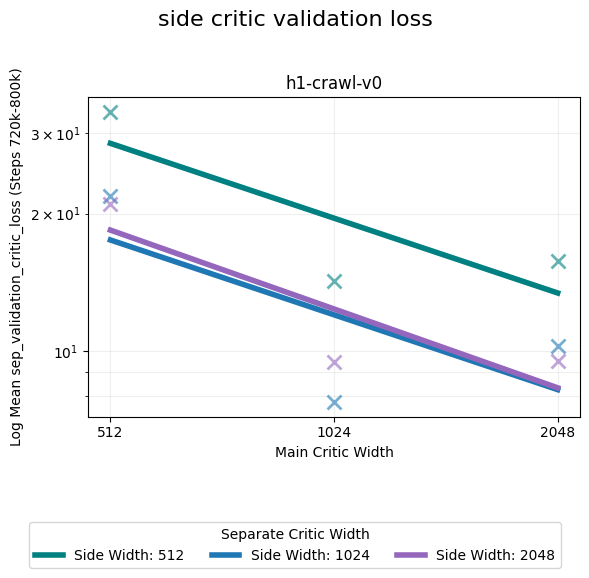

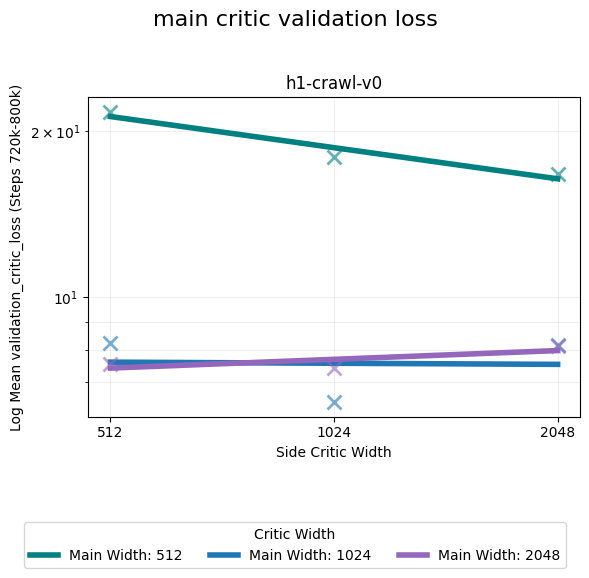

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib.ticker import FuncFormatter  # For x-axis log scale formatting


# Helper function to calculate the summary metric for a single row
def _calculate_summary_metric_for_row(
    row, training_step_col_name, metric_values_col_name, start_step, end_step
):
    try:
        steps = np.asarray(row[training_step_col_name])
        metric_values = np.asarray(row[metric_values_col_name])
    except Exception:
        return np.nan

    if steps.ndim == 0 or metric_values.ndim == 0 or steps.size == 0 or metric_values.size == 0:
        return np.nan

    if steps.size != metric_values.size:
        return np.nan

    mask = (steps >= start_step) & (steps <= end_step)
    relevant_metric_values = metric_values[mask]

    if relevant_metric_values.size > 0:
        return np.nanmean(relevant_metric_values)
    else:
        return np.nan


def aggregate_last_10_percent(df, metric, suptitle, group_main):
    metric_col_name = f'mean_{metric}'
    if metric_col_name not in df.columns:
        if metric in df.columns:
            metric_col_name = metric
        else:
            print(
                f"Error: Metric column '{f'mean_{metric}'}' or '{metric}' not found. Available: {df.columns.tolist()}"
            )
            return

    start_step_for_avg = 720000
    end_step_for_avg = 800000

    df_copy = df.copy()
    df_copy['summary_metric'] = df_copy.apply(
        lambda row: _calculate_summary_metric_for_row(
            row, 'training_step', metric_col_name, start_step_for_avg, end_step_for_avg
        ),
        axis=1,
    )

    df_processed = df_copy.dropna(subset=['summary_metric'])

    if df_processed.empty:
        print(
            f"Warning: No data found or processed for metric '{metric}' in the step range {start_step_for_avg}-{end_step_for_avg}."
        )
        return

    identifying_cols = ['env_name', 'critic_width', 'separate_critic_width']
    missing_id_cols = [col for col in identifying_cols if col not in df_processed.columns]
    if missing_id_cols:
        print(
            f'Error: DataFrame is missing identifying columns: {missing_id_cols}. Available: {df_processed.columns.tolist()}'
        )
        return

    df_plot_ready = df_processed.groupby(identifying_cols, as_index=False)['summary_metric'].mean()

    df_plot_ready['critic_width'] = pd.to_numeric(df_plot_ready['critic_width'])
    df_plot_ready['separate_critic_width'] = pd.to_numeric(df_plot_ready['separate_critic_width'])

    if group_main:
        x_axis_col = 'critic_width'
        color_col = 'separate_critic_width'
        x_label = 'Main Critic Width'
        color_label_prefix = 'Side Width: '
    else:
        x_axis_col = 'separate_critic_width'
        color_col = 'critic_width'
        x_label = 'Side Critic Width'
        color_label_prefix = 'Main Width: '

    unique_envs = sorted(df_plot_ready['env_name'].unique())
    num_envs = len(unique_envs)

    if num_envs == 0:
        print('No environments found to plot.')
        return

    fig, axes = plt.subplots(1, num_envs, figsize=(6 * num_envs, 5), sharey=True)
    if num_envs == 1:  # Ensure axes is always an array
        axes = [axes]

    lines_for_legend = []
    labels_for_legend = {}  # Use dict to store unique labels and associated lines

    fixed_color_map = {512: 'teal', 1024: 'tab:blue', 2048: 'tab:purple'}
    # Determine all unique color values across all environments for consistent coloring
    all_color_values = sorted(df_plot_ready[color_col].unique())
    num_unique_color_vals = len(all_color_values)
    default_colors = plt.cm.viridis(np.linspace(0, 1, max(1, num_unique_color_vals)))

    color_palette = {}
    for i, c_val in enumerate(all_color_values):
        color_palette[c_val] = fixed_color_map.get(
            c_val, default_colors[i] if num_unique_color_vals > 0 else 'blue'
        )

    for idx, env in enumerate(unique_envs):
        ax = axes[idx]
        env_group = df_plot_ready[df_plot_ready['env_name'] == env]

        if env_group.empty:
            ax.set_title(f'{env}\n(No data)')
            ax.text(
                0.5,
                0.5,
                'No data',
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes,
            )
            continue

        current_color_values_in_env = sorted(env_group[color_col].unique())

        for (
            c_val
        ) in current_color_values_in_env:  # Iterate using pre-calculated unique values for this env
            subset = env_group[env_group[color_col] == c_val]
            subset_sorted = subset.sort_values(by=x_axis_col)

            current_color = color_palette[c_val]
            label = f'{color_label_prefix}{c_val}'

            # log-log plot
            smooth_x = np.log(subset_sorted[x_axis_col])
            smooth_y = np.log(subset_sorted['summary_metric'])
            linear_fit = sm.OLS(smooth_y, sm.add_constant(smooth_x)).fit()
            y_fit = linear_fit.predict(sm.add_constant(smooth_x))

            (line,) = ax.plot(
                np.exp(smooth_x),
                np.exp(smooth_y),
                # label=label, # Set label for legend later
                color=current_color,
                marker='x',
                markersize=10,
                markeredgewidth=2,
                linestyle='None',
                alpha=0.6,
            )
            (line,) = ax.plot(
                np.exp(smooth_x),
                np.exp(y_fit),
                color=current_color,
                linestyle='-',
                linewidth=4,
                alpha=1,
            )
            if label not in labels_for_legend:
                labels_for_legend[label] = line

        ax.set_xlabel(x_label)
        if idx == 0:  # Set Y-axis label only for the first plot
            ax.set_ylabel(
                f'Log Mean {metric} (Steps {start_step_for_avg / 1000:.0f}k-{end_step_for_avg / 1000:.0f}k)'
            )
        ax.set_title(f'{env}')
        ax.set_yscale('log')

        unique_x_ticks = sorted(env_group[x_axis_col].unique())
        if len(unique_x_ticks) > 0:
            ax.set_xticks(unique_x_ticks)
            use_log_scale_x = False
            if len(unique_x_ticks) >= 2 and all(x > 0 for x in unique_x_ticks):
                if max(unique_x_ticks) / min(unique_x_ticks) >= 3:
                    are_powers_of_two = [(x > 0 and (x & (x - 1) == 0)) for x in unique_x_ticks]
                    if (
                        sum(are_powers_of_two) / len(unique_x_ticks) >= 0.5
                        or len(unique_x_ticks) > 3
                    ):
                        use_log_scale_x = True

            # zhouzpaul override
            use_log_scale_x = True

            if use_log_scale_x:
                ax.set_xscale('log', base=2)
                ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f'{int(val)}'))
            else:
                ax.set_xticklabels([str(int(x)) for x in unique_x_ticks])

        ax.grid(True, which='both', ls='-', alpha=0.2)  # Add a light grid

    # Create a single legend for the entire figure
    # Sort legend items by the numeric part of the label (width)
    sorted_legend_items = sorted(
        labels_for_legend.items(), key=lambda item: int(str(item[0]).split(':')[-1].strip())
    )

    fig.legend(
        [item[1] for item in sorted_legend_items],
        [item[0] for item in sorted_legend_items],
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05 if num_envs > 2 else -0.15),  # Adjust bbox based on num_envs
        ncol=min(len(labels_for_legend), 4),  # Max 4 columns for legend
        title=color_col.replace('_', ' ').title(),
    )

    fig.suptitle(f'{suptitle}', fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout to make space for legend and suptitle
    plt.show()


env_df = df.query('env_name == "h1-crawl-v0"')
aggregate_last_10_percent(
    env_df, 'sep_validation_critic_loss', 'side critic validation loss', group_main=True
)
aggregate_last_10_percent(
    env_df, 'validation_critic_loss', 'main critic validation loss', group_main=False
)

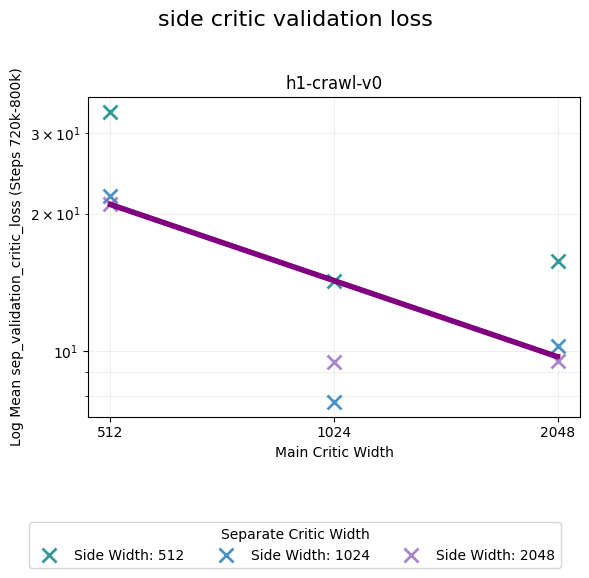

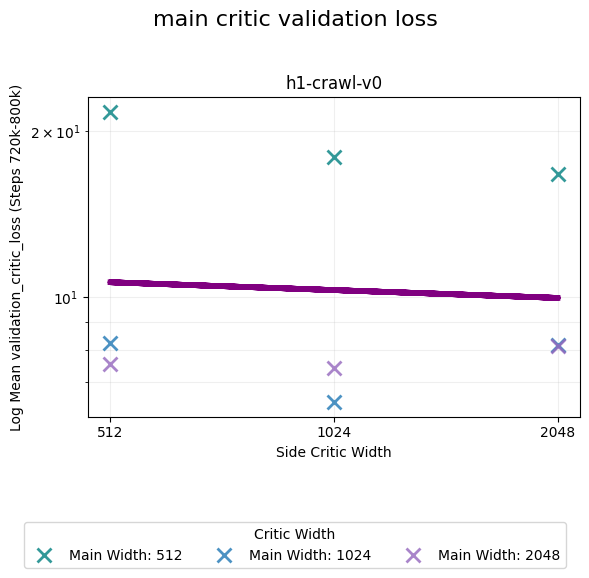

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib.ticker import FuncFormatter  # For x-axis log scale formatting


# Helper function to calculate the summary metric for a single row
def _calculate_summary_metric_for_row(
    row, training_step_col_name, metric_values_col_name, start_step, end_step
):
    try:
        steps = np.asarray(row[training_step_col_name])
        metric_values = np.asarray(row[metric_values_col_name])
    except Exception:
        return np.nan

    if steps.ndim == 0 or metric_values.ndim == 0 or steps.size == 0 or metric_values.size == 0:
        return np.nan

    if steps.size != metric_values.size:
        return np.nan

    mask = (steps >= start_step) & (steps <= end_step)
    relevant_metric_values = metric_values[mask]

    if relevant_metric_values.size > 0:
        return np.nanmean(relevant_metric_values)
    else:
        return np.nan


def aggregate_last_10_percent(df, metric, suptitle, group_main):
    metric_col_name = f'mean_{metric}'
    if metric_col_name not in df.columns:
        if metric in df.columns:
            metric_col_name = metric
        else:
            print(
                f"Error: Metric column '{f'mean_{metric}'}' or '{metric}' not found. Available: {df.columns.tolist()}"
            )
            return

    start_step_for_avg = 720000
    end_step_for_avg = 800000

    df_copy = df.copy()
    df_copy['summary_metric'] = df_copy.apply(
        lambda row: _calculate_summary_metric_for_row(
            row, 'training_step', metric_col_name, start_step_for_avg, end_step_for_avg
        ),
        axis=1,
    )

    df_processed = df_copy.dropna(subset=['summary_metric'])

    if df_processed.empty:
        print(
            f"Warning: No data found or processed for metric '{metric}' in the step range {start_step_for_avg}-{end_step_for_avg}."
        )
        return

    identifying_cols = ['env_name', 'critic_width', 'separate_critic_width']
    missing_id_cols = [col for col in identifying_cols if col not in df_processed.columns]
    if missing_id_cols:
        print(
            f'Error: DataFrame is missing identifying columns: {missing_id_cols}. Available: {df_processed.columns.tolist()}'
        )
        return

    df_plot_ready = df_processed.groupby(identifying_cols, as_index=False)['summary_metric'].mean()

    df_plot_ready['critic_width'] = pd.to_numeric(df_plot_ready['critic_width'])
    df_plot_ready['separate_critic_width'] = pd.to_numeric(df_plot_ready['separate_critic_width'])

    if group_main:
        x_axis_col = 'critic_width'
        color_col = 'separate_critic_width'
        x_label = 'Main Critic Width'
        color_label_prefix = 'Side Width: '
    else:
        x_axis_col = 'separate_critic_width'
        color_col = 'critic_width'
        x_label = 'Side Critic Width'
        color_label_prefix = 'Main Width: '

    unique_envs = sorted(df_plot_ready['env_name'].unique())
    num_envs = len(unique_envs)

    if num_envs == 0:
        print('No environments found to plot.')
        return

    fig, axes = plt.subplots(1, num_envs, figsize=(6 * num_envs, 5), sharey=True)
    if num_envs == 1:  # Ensure axes is always an array
        axes = [axes]

    lines_for_legend = []
    labels_for_legend = {}  # Use dict to store unique labels and associated lines

    fixed_color_map = {512: 'teal', 1024: 'tab:blue', 2048: 'tab:purple'}
    # Determine all unique color values across all environments for consistent coloring
    all_color_values = sorted(df_plot_ready[color_col].unique())
    num_unique_color_vals = len(all_color_values)
    default_colors = plt.cm.viridis(np.linspace(0, 1, max(1, num_unique_color_vals)))

    color_palette = {}
    for i, c_val in enumerate(all_color_values):
        color_palette[c_val] = fixed_color_map.get(
            c_val, default_colors[i] if num_unique_color_vals > 0 else 'blue'
        )

    for idx, env in enumerate(unique_envs):
        ax = axes[idx]
        env_group = df_plot_ready[df_plot_ready['env_name'] == env]

        if env_group.empty:
            ax.set_title(f'{env}\n(No data)')
            ax.text(
                0.5,
                0.5,
                'No data',
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes,
            )
            continue

        current_color_values_in_env = sorted(env_group[color_col].unique())

        for (
            c_val
        ) in current_color_values_in_env:  # Iterate using pre-calculated unique values for this env
            subset = env_group[env_group[color_col] == c_val]
            subset_sorted = subset.sort_values(by=x_axis_col)

            current_color = color_palette[c_val]
            label = f'{color_label_prefix}{c_val}'

            # log-log plot
            smooth_x = np.log(subset_sorted[x_axis_col])
            smooth_y = np.log(subset_sorted['summary_metric'])

            (line,) = ax.plot(
                np.exp(smooth_x),
                np.exp(smooth_y),
                # label=label, # Set label for legend later
                color=current_color,
                marker='x',
                markersize=10,
                markeredgewidth=2,
                linestyle='None',
                alpha=0.8,
            )

            if label not in labels_for_legend:
                labels_for_legend[label] = line

        # plot a linear fit for all points
        smooth_x = np.log(env_group[x_axis_col])
        smooth_y = np.log(env_group['summary_metric'])

        linear_fit = sm.OLS(smooth_y, sm.add_constant(smooth_x)).fit()
        y_fit = linear_fit.predict(sm.add_constant(smooth_x))

        (line,) = ax.plot(
            np.exp(smooth_x),
            np.exp(y_fit),
            color='purple',
            linestyle='-',
            linewidth=4,
            alpha=1,
        )

        ax.set_xlabel(x_label)
        if idx == 0:  # Set Y-axis label only for the first plot
            ax.set_ylabel(
                f'Log Mean {metric} (Steps {start_step_for_avg / 1000:.0f}k-{end_step_for_avg / 1000:.0f}k)'
            )
        ax.set_title(f'{env}')
        ax.set_yscale('log')

        unique_x_ticks = sorted(env_group[x_axis_col].unique())
        if len(unique_x_ticks) > 0:
            ax.set_xticks(unique_x_ticks)
            use_log_scale_x = False
            if len(unique_x_ticks) >= 2 and all(x > 0 for x in unique_x_ticks):
                if max(unique_x_ticks) / min(unique_x_ticks) >= 3:
                    are_powers_of_two = [(x > 0 and (x & (x - 1) == 0)) for x in unique_x_ticks]
                    if (
                        sum(are_powers_of_two) / len(unique_x_ticks) >= 0.5
                        or len(unique_x_ticks) > 3
                    ):
                        use_log_scale_x = True

            # zhouzpaul override
            use_log_scale_x = True

            if use_log_scale_x:
                ax.set_xscale('log', base=2)
                ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f'{int(val)}'))
            else:
                ax.set_xticklabels([str(int(x)) for x in unique_x_ticks])

        ax.grid(True, which='both', ls='-', alpha=0.2)  # Add a light grid

    # Create a single legend for the entire figure
    # Sort legend items by the numeric part of the label (width)
    sorted_legend_items = sorted(
        labels_for_legend.items(), key=lambda item: int(str(item[0]).split(':')[-1].strip())
    )

    fig.legend(
        [item[1] for item in sorted_legend_items],
        [item[0] for item in sorted_legend_items],
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05 if num_envs > 2 else -0.15),  # Adjust bbox based on num_envs
        ncol=min(len(labels_for_legend), 4),  # Max 4 columns for legend
        title=color_col.replace('_', ' ').title(),
    )

    fig.suptitle(f'{suptitle}', fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout to make space for legend and suptitle
    plt.show()


env_df = df.query('env_name == "h1-crawl-v0"')
aggregate_last_10_percent(
    env_df, 'sep_validation_critic_loss', 'side critic validation loss', group_main=True
)
aggregate_last_10_percent(
    env_df, 'validation_critic_loss', 'main critic validation loss', group_main=False
)

/tmp/ipykernel_1548407/595184874.py:142: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter = ax.scatter(
/tmp/ipykernel_1548407/595184874.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]
/tmp/ipykernel_1548407/595184874.py:142: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter = ax.scatter(
/tmp/ipykernel_1548407/595184874.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (

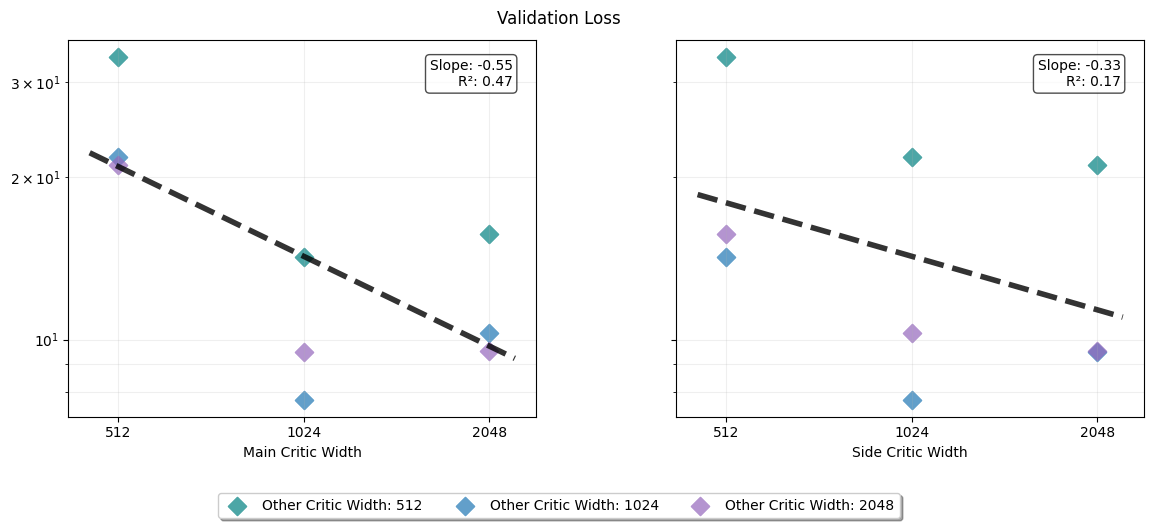

In [12]:
def aggregate_two_metrics_side_by_side(
    df, metric1, metric2, suptitle1, suptitle2, group_main1, group_main2
):
    """
    Plot two metrics side by side for each environment.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the data to plot.
    metric1, metric2 : str
        The names of the metrics to plot.
    suptitle1, suptitle2 : str
        The subtitles for each metric.
    group_main1, group_main2 : bool
        Whether to group by main critic width (True) or side critic width (False) for each metric.
    """
    # Common parameters
    start_step_for_avg = 720000
    end_step_for_avg = 800000

    # Process data for both metrics
    metrics = [metric1, metric2]
    group_mains = [group_main1, group_main2]
    suptitles = [suptitle1, suptitle2]

    # Prepare data for both metrics
    all_data = []

    for metric, group_main in zip(metrics, group_mains):
        metric_col_name = f'mean_{metric}'
        if metric_col_name not in df.columns:
            if metric in df.columns:
                metric_col_name = metric
            else:
                print(
                    f"Error: Metric column '{f'mean_{metric}'}' or '{metric}' not found. Available: {df.columns.tolist()}"
                )
                return

        df_copy = df.copy()
        df_copy['summary_metric'] = df_copy.apply(
            lambda row: _calculate_summary_metric_for_row(
                row, 'training_step', metric_col_name, start_step_for_avg, end_step_for_avg
            ),
            axis=1,
        )

        df_processed = df_copy.dropna(subset=['summary_metric'])

        if df_processed.empty:
            print(
                f"Warning: No data found or processed for metric '{metric}' in the step range {start_step_for_avg}-{end_step_for_avg}."
            )
            return

        identifying_cols = ['env_name', 'critic_width', 'separate_critic_width']
        missing_id_cols = [col for col in identifying_cols if col not in df_processed.columns]
        if missing_id_cols:
            print(
                f'Error: DataFrame is missing identifying columns: {missing_id_cols}. Available: {df_processed.columns.tolist()}'
            )
            return

        df_plot_ready = df_processed.groupby(identifying_cols, as_index=False)[
            'summary_metric'
        ].mean()
        df_plot_ready['critic_width'] = pd.to_numeric(df_plot_ready['critic_width'])
        df_plot_ready['separate_critic_width'] = pd.to_numeric(
            df_plot_ready['separate_critic_width']
        )

        # Store processed data
        all_data.append(
            {
                'df': df_plot_ready,
                'metric': metric,
                'group_main': group_main,
                'suptitle': suptitles[len(all_data)],
            }
        )

    # Get unique environments
    unique_envs = sorted(
        set(all_data[0]['df']['env_name'].unique()).union(all_data[1]['df']['env_name'].unique())
    )
    num_envs = len(unique_envs)

    if num_envs == 0:
        print('No environments found to plot.')
        return

    # Create figure with num_envs rows and 2 columns (one column for each metric)
    fig, axes = plt.subplots(num_envs, 2, figsize=(12, 5 * num_envs), sharey='row')

    # Ensure axes is always a 2D array
    if num_envs == 1:
        axes = np.array(axes).reshape(1, 2)

    # For legend
    points_for_legend = []
    fit_lines_for_legend = []
    labels_for_legend = []
    fit_line_labels = []

    # Process each environment (row)
    for row_idx, env in enumerate(unique_envs):
        # Process each metric (column)
        for col_idx, data in enumerate(all_data):
            df_plot_ready = data['df']
            metric = data['metric']
            group_main = data['group_main']
            suptitle = data['suptitle']

            if group_main:
                x_axis_col = 'critic_width'
                color_col = 'separate_critic_width'
                x_label = 'Main Critic Width'
                color_label_prefix = 'Other Critic Width: '
            else:
                x_axis_col = 'separate_critic_width'
                color_col = 'critic_width'
                x_label = 'Side Critic Width'
                color_label_prefix = 'Other Critic Width: '

            ax = axes[row_idx, col_idx]
            env_group = df_plot_ready[df_plot_ready['env_name'] == env]

            if env_group.empty:
                # ax.set_title(f'{suptitle}\n(No data)')
                ax.text(
                    0.5,
                    0.5,
                    'No data',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=ax.transAxes,
                )
                continue

            # Color palette
            fixed_color_map = {512: 'teal', 1024: 'tab:blue', 2048: 'tab:purple'}
            all_color_values = sorted(df_plot_ready[color_col].unique())
            num_unique_color_vals = len(all_color_values)
            default_colors = plt.cm.viridis(np.linspace(0, 1, max(1, num_unique_color_vals)))

            color_palette = {}
            for i, c_val in enumerate(all_color_values):
                color_palette[c_val] = fixed_color_map.get(
                    c_val, default_colors[i] if num_unique_color_vals > 0 else 'blue'
                )

            current_color_values_in_env = sorted(env_group[color_col].unique())

            # Plot scatter points for each color value
            for c_val in current_color_values_in_env:
                subset = env_group[env_group[color_col] == c_val]

                current_color = color_palette[c_val]
                label = f'{color_label_prefix}{c_val}'

                # Plot only points, no connecting lines
                scatter = ax.scatter(
                    subset[x_axis_col],
                    subset['summary_metric'],
                    color=current_color,
                    s=50,  # Slightly larger points
                    alpha=0.7,
                    marker='x',
                    edgecolors='white',
                    linewidth=10.0,
                )

                # Add to legend only if this is the first environment and first metric
                if row_idx == 0 and col_idx == 0:
                    points_for_legend.append(scatter)
                    labels_for_legend.append(label)

            # Fit a single linear regression on log-log scale for all points in this environment
            if len(env_group) >= 2:  # Need at least 2 points for a line
                log_x = np.log(env_group[x_axis_col])
                log_y = np.log(env_group['summary_metric'])

                # Add constant for intercept
                X = sm.add_constant(log_x)

                # Fit linear model on log-log scale
                try:
                    model = sm.OLS(log_y, X).fit()

                    # Generate smooth curve for plotting
                    x_min, x_max = env_group[x_axis_col].min(), env_group[x_axis_col].max()
                    x_range = np.exp(np.linspace(np.log(x_min * 0.9), np.log(x_max * 1.1), 100))

                    # Predict using the model
                    X_smooth = sm.add_constant(np.log(x_range))
                    log_y_pred = model.predict(X_smooth)
                    y_pred = np.exp(log_y_pred)

                    # Plot the fit line
                    fit_line = ax.plot(
                        x_range, y_pred, color='black', linestyle='--', linewidth=4, alpha=0.8
                    )[0]

                    # Calculate slope and R²
                    slope = model.params[1]
                    r_squared = model.rsquared

                    # Add fit line to legend if this is the first environment and first metric
                    if row_idx == 0 and col_idx == 0:
                        fit_lines_for_legend.append(fit_line)
                        fit_line_labels.append(f'Slope: {slope:.2f}, R²: {r_squared:.2f}')

                    # Annotate the plot with slope and R²
                    ax.text(
                        0.95,
                        0.95,
                        f'Slope: {slope:.2f}\nR²: {r_squared:.2f}',
                        transform=ax.transAxes,
                        verticalalignment='top',
                        horizontalalignment='right',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
                    )
                except Exception as e:
                    print(
                        f'Warning: Could not fit linear model for environment {env}, metric {metric}. Error: {e}'
                    )

            # Set title
            # ax.set_title(f'{suptitle}')

            # Set labels
            ax.set_xlabel(x_label)
            # if col_idx == 0:  # Set Y-axis label only for the first column
            # ax.set_ylabel(f'Mean {metric}\n(Steps {start_step_for_avg/1000:.0f}k-{end_step_for_avg/1000:.0f}k)')

            ax.set_yscale('log')
            ax.set_xscale('log', base=2)

            # Set x-ticks to the actual data points
            unique_x_ticks = sorted(env_group[x_axis_col].unique())
            if len(unique_x_ticks) > 0:
                ax.set_xticks(unique_x_ticks)
                ax.set_xticklabels([str(int(x)) for x in unique_x_ticks])

            ax.grid(True, which='both', ls='-', alpha=0.2)  # Add a light grid

        # Add row title (environment name)
        # fig.text(0.01, 0.5 + (0.5 - row_idx) * (1.0/num_envs), env, fontsize=14, rotation=90, va='center')

    # Create a combined legend with both points and fit line
    if labels_for_legend:  # Check if we have any legend items
        sorted_idx = sorted(
            range(len(labels_for_legend)),
            key=lambda i: int(labels_for_legend[i].split(':')[-1].strip()),
        )
        sorted_points = [points_for_legend[i] for i in sorted_idx]
        sorted_labels = [labels_for_legend[i] for i in sorted_idx]

        # Combine all legend elements
        all_legend_elements = sorted_points  # + fit_lines_for_legend
        all_legend_labels = sorted_labels  # + fit_line_labels

        # Place the legend
        fig.legend(
            all_legend_elements,
            all_legend_labels,
            loc='lower center',
            bbox_to_anchor=(0.5, -0.05),
            ncol=min(len(all_legend_labels), 4),
            frameon=True,
            fancybox=True,
            shadow=True,
        )

    plt.tight_layout(
        rect=[0.03, 0.05, 1, 0.95]
    )  # Adjust layout to make space for legend and row titles
    plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Add some space between subplots
    plt.suptitle('Validation Loss')
    plt.show()


aggregate_two_metrics_side_by_side(
    env_df,
    'sep_validation_critic_loss',
    'sep_validation_critic_loss',
    'Validation Loss',
    'Validation Loss',
    True,  # group_main for the first metric
    False,  # group_main for the second metric
)

In [ ]:
"""
anonymous: rliable example code from Oleg
"""

# Plot all environments in one plot
reg_shared, X_all, y_all, env_indices, n_envs = fit_shared_slope_regression(
    df_best_lr_bs, envs, y_col='best_bs_bootstrap_lrmean'
)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(496.0 / 192 * 2, 369.6 / 192 * 2)

# Get the slope coefficient (shared across environments)
slope = reg_shared.coef_[0]

for i, (env, color) in enumerate(zip(envs, colors)):
    # Get predictions
    X_plot = np.linspace(X_all.min(), X_all.max(), 100).reshape(-1, 1)
    env_dummies_plot = np.zeros((len(X_plot), n_envs - 1))
    if i > 0:
        env_dummies_plot[:, i - 1] = 1
    X_combined_plot = np.hstack([X_plot, env_dummies_plot])
    y_plot = reg_shared.predict(X_combined_plot)

    # Get intercept for this environment
    if i == 0:
        intercept = reg_shared.intercept_
    else:
        intercept = reg_shared.intercept_ + reg_shared.coef_[i]
    shift = intercept - reg_shared.intercept_

    # Plot data points for this environment
    mask = env_indices == i
    plt.scatter(
        10 ** X_all[mask], 10 ** (y_all[mask] - shift), marker='o', color=COLORS[1], alpha=0.8, s=80
    )

# Plot regression line using slope and intercept directly
y_plot_direct = slope * X_plot + intercept - shift
plt.plot(
    10**X_plot, 10 ** y_plot_direct.flatten(), color=COLORS[1], linewidth=3, label='$B^*(\sigma)$'
)

# Fit separate regression for each environment
r2_scores = []
for i, env in enumerate(envs):
    # Get data for this environment
    mask = env_indices == i
    X_env = X_all[mask].reshape(-1, 1)
    y_env = y_all[mask]

    # Calculate mean for constant fit
    y_mean = np.mean(y_env)

    # Get predictions (constant line at mean)
    X_plot = np.linspace(X_all.min(), X_all.max(), 100).reshape(-1, 1)
    # Get intercept for this environment
    if i == 0:
        shift = 0
    else:
        shift = reg_shared.coef_[i]
    y_plot = np.full_like(X_plot, y_mean - shift)

    # Plot constant line
plt.plot(
    10**X_plot,
    10 ** y_plot.flatten(),
    '--',
    color=COLORS[4],
    alpha=0.5,
    label='Constant fit',
    linewidth=3,
)

plt.xscale('log')
plt.yscale('log')
ax.legend(prop={'size': 14}, ncol=1, frameon=False, loc='lower left')

x = np.logspace(np.log10(1), np.log10(8), num=4)
x_ticks_labels = [f'{x:.0f}' for x in x]
ax.xaxis.set_major_locator(plt.FixedLocator(x))
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_xticks(x, x_ticks_labels)

yticks = np.logspace(np.log10(128), np.log10(512), num=3)
ylabels = ['%.0f' % (y) for y in yticks]
ax.yaxis.set_major_locator(plt.FixedLocator(yticks))
ax.yaxis.set_minor_locator(plt.NullLocator())
ax.set_yticks(yticks, ylabels, size=14.5)

plot_utils._annotate_and_decorate_axis(
    ax,
    xlabel='$\sigma$: UTD ratio',
    ylabel='$B^*$: Best batch size',
    labelsize='xx-large',
    ticklabelsize='xx-large',
    grid_alpha=0.2,
    legend=False,
)

# plt.text(1.04, -0.14, '×1e4', transform=ax.transAxes,
#          horizontalalignment='right', verticalalignment='bottom',
#          fontsize='x-large', alpha=0.8)
# plt.text(-0.04, 0.93, '×1e7', transform=ax.transAxes,
#          horizontalalignment='right', verticalalignment='bottom',
#          fontsize='x-large', alpha=0.8)

plt.tight_layout()
plt.savefig('dmc_batch_size_vs_utd.pdf', dpi=300, bbox_inches='tight')


from rliable import plot_utils

COLORS = [
    '#BBCC33',
    '#77AADD',
    '#44BB99',
    '#EEDD88',
    '#EE8866',
    '#FFAABB',
    '#99DDFF',
    '#44BB99',
    '#AAAA00',
    '#DDDDDD',
]
palette = sns.set_palette(COLORS)
plt.rcParams['text.usetex'] = False  # Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = (
    r'\usepackage{sansmath} \sansmath'  # Force sans-serif math mode (for axes labels)
)
plt.rcParams['font.family'] = 'sans-serif'  # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue']  # Choose a nice font here
sns.set_style('whitegrid')

from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('custom_gradient', [COLORS[0], COLORS[1]])
n_colors = n_thresholds
colors = [cmap(i / (n_colors - 1)) for i in range(n_colors)]

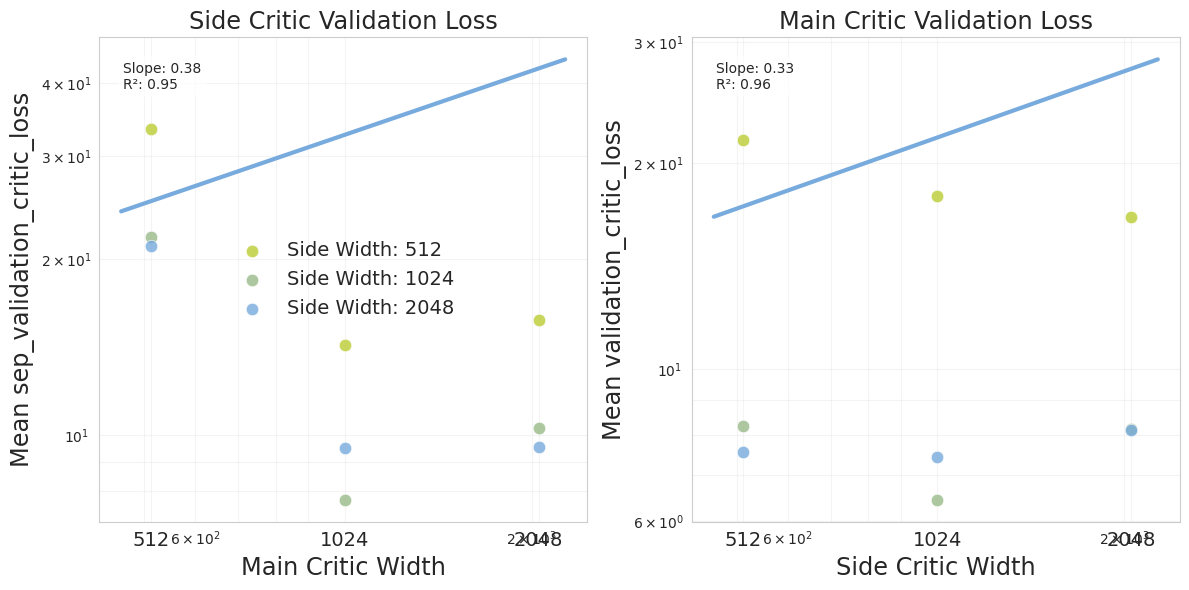

In [ ]:
"""anonymous: rliable style generated by claude 3.7"""


def plot_critic_widths_rliable_style(
    df, metric1, metric2, suptitle1, suptitle2, group_main1, group_main2
):
    """
    Plot two metrics side by side in rliable style.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the data to plot.
    metric1, metric2 : str
        The names of the metrics to plot.
    suptitle1, suptitle2 : str
        The subtitles for each metric.
    group_main1, group_main2 : bool
        Whether to group by main critic width (True) or side critic width (False) for each metric.
    """
    # Import required libraries for rliable style
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Set up rliable color scheme
    COLORS = [
        '#BBCC33',
        '#77AADD',
        '#44BB99',
        '#EEDD88',
        '#EE8866',
        '#FFAABB',
        '#99DDFF',
        '#44BB99',
        '#AAAA00',
        '#DDDDDD',
    ]

    # Apply rliable styling
    plt.rcParams['text.usetex'] = False
    plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath} \sansmath'
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Helveta Nue']
    sns.set_style('whitegrid')

    # Common parameters
    start_step_for_avg = 720000
    end_step_for_avg = 800000

    # Process data for both metrics
    metrics = [metric1, metric2]
    group_mains = [group_main1, group_main2]
    suptitles = [suptitle1, suptitle2]

    # Prepare data for both metrics
    all_data = []

    for metric, group_main in zip(metrics, group_mains):
        metric_col_name = f'mean_{metric}'
        if metric_col_name not in df.columns:
            if metric in df.columns:
                metric_col_name = metric
            else:
                print(
                    f"Error: Metric column '{f'mean_{metric}'}' or '{metric}' not found. Available: {df.columns.tolist()}"
                )
                return

        df_copy = df.copy()
        df_copy['summary_metric'] = df_copy.apply(
            lambda row: _calculate_summary_metric_for_row(
                row, 'training_step', metric_col_name, start_step_for_avg, end_step_for_avg
            ),
            axis=1,
        )

        df_processed = df_copy.dropna(subset=['summary_metric'])

        if df_processed.empty:
            print(
                f"Warning: No data found or processed for metric '{metric}' in the step range {start_step_for_avg}-{end_step_for_avg}."
            )
            return

        identifying_cols = ['env_name', 'critic_width', 'separate_critic_width']
        missing_id_cols = [col for col in identifying_cols if col not in df_processed.columns]
        if missing_id_cols:
            print(
                f'Error: DataFrame is missing identifying columns: {missing_id_cols}. Available: {df_processed.columns.tolist()}'
            )
            return

        df_plot_ready = df_processed.groupby(identifying_cols, as_index=False)[
            'summary_metric'
        ].mean()
        df_plot_ready['critic_width'] = pd.to_numeric(df_plot_ready['critic_width'])
        df_plot_ready['separate_critic_width'] = pd.to_numeric(
            df_plot_ready['separate_critic_width']
        )

        # Store processed data
        all_data.append(
            {
                'df': df_plot_ready,
                'metric': metric,
                'group_main': group_main,
                'suptitle': suptitles[len(all_data)],
            }
        )

    # Get unique environments
    unique_envs = sorted(
        set(all_data[0]['df']['env_name'].unique()).union(all_data[1]['df']['env_name'].unique())
    )
    num_envs = len(unique_envs)

    if num_envs == 0:
        print('No environments found to plot.')
        return

    # Create figure with 1 row and 2 columns (one for each metric)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Process each metric (column)
    for col_idx, data in enumerate(all_data):
        df_plot_ready = data['df']
        metric = data['metric']
        group_main = data['group_main']
        suptitle = data['suptitle']

        if group_main:
            x_axis_col = 'critic_width'
            color_col = 'separate_critic_width'
            x_label = 'Main Critic Width'
            color_label_prefix = 'Side Width: '
        else:
            x_axis_col = 'separate_critic_width'
            color_col = 'critic_width'
            x_label = 'Side Critic Width'
            color_label_prefix = 'Main Width: '

        ax = axes[col_idx]

        # Get all unique color values across all environments
        all_color_values = sorted(df_plot_ready[color_col].unique())
        n_colors = len(all_color_values)

        # Create color gradient using rliable style
        from matplotlib.colors import LinearSegmentedColormap

        cmap = LinearSegmentedColormap.from_list('custom_gradient', [COLORS[0], COLORS[1]])
        colors = [cmap(i / max(1, (n_colors - 1))) for i in range(n_colors)]

        # Create a mapping from color values to colors
        color_mapping = {val: colors[i] for i, val in enumerate(all_color_values)}

        # For legend
        scatter_handles = []
        scatter_labels = []

        # Plot each environment with different markers
        env_markers = [
            'o',
            's',
            '^',
            'D',
            'v',
            '<',
            '>',
            'p',
            '*',
        ]  # Different markers for different environments

        # Collect all X and Y values for regression
        all_log_x = []
        all_log_y = []
        all_env_indices = []

        for env_idx, env in enumerate(unique_envs):
            marker = env_markers[env_idx % len(env_markers)]

            for color_idx, color_val in enumerate(all_color_values):
                # Filter data for this environment and color value
                env_color_data = df_plot_ready[
                    (df_plot_ready['env_name'] == env) & (df_plot_ready[color_col] == color_val)
                ]

                if len(env_color_data) == 0:
                    continue

                # Plot scatter points
                scatter = ax.scatter(
                    env_color_data[x_axis_col],
                    env_color_data['summary_metric'],
                    color=color_mapping[color_val],
                    s=80,
                    alpha=0.8,
                    marker=marker,
                    edgecolors='white',
                    linewidth=0.5,
                )

                # Add to legend only once per color value
                if env_idx == 0:
                    scatter_handles.append(scatter)
                    scatter_labels.append(f'{color_label_prefix}{color_val}')

                # Collect data for regression
                log_x = np.log10(env_color_data[x_axis_col].values)
                log_y = np.log10(env_color_data['summary_metric'].values)

                all_log_x.extend(log_x)
                all_log_y.extend(log_y)
                all_env_indices.extend([env_idx] * len(log_x))

        # Convert to numpy arrays
        all_log_x = np.array(all_log_x).reshape(-1, 1)
        all_log_y = np.array(all_log_y)
        all_env_indices = np.array(all_env_indices)

        # Fit linear regression on log-log scale
        if len(all_log_x) >= 2:
            # Create environment dummy variables for shared slope regression
            n_envs = len(unique_envs)
            env_dummies = np.zeros((len(all_log_x), n_envs - 1))
            for i in range(1, n_envs):
                env_dummies[:, i - 1] = (all_env_indices == i).astype(int)

            # Combine X with environment dummies
            X_combined = np.hstack([all_log_x, env_dummies])

            # Fit shared slope regression
            reg_shared = sm.OLS(all_log_y, X_combined).fit()

            # Get the slope coefficient (shared across environments)
            slope = reg_shared.params[0]

            # Plot regression line
            x_plot = np.linspace(
                np.log10(min(df_plot_ready[x_axis_col]) * 0.9),
                np.log10(max(df_plot_ready[x_axis_col]) * 1.1),
                100,
            ).reshape(-1, 1)

            # Plot a single regression line with the shared slope
            y_plot = slope * x_plot + reg_shared.params[0]
            ax.plot(
                10 ** x_plot.flatten(),
                10 ** y_plot.flatten(),
                color=COLORS[1],
                linewidth=3,
                label=f'Slope: {slope:.2f}',
            )

            # Add annotation with slope and R²
            ax.text(
                0.05,
                0.95,
                f'Slope: {slope:.2f}\nR²: {reg_shared.rsquared:.2f}',
                transform=ax.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
            )

        # Set axis properties
        ax.set_xscale('log', base=10)
        ax.set_yscale('log', base=10)

        # Set x-ticks to the actual data points
        unique_x_ticks = sorted(df_plot_ready[x_axis_col].unique())
        if len(unique_x_ticks) > 0:
            ax.set_xticks(unique_x_ticks)
            ax.set_xticklabels([str(int(x)) for x in unique_x_ticks], size=14)

        # Set labels and title
        ax.set_xlabel(x_label, fontsize='xx-large')
        ax.set_ylabel(f'Mean {metric}', fontsize='xx-large')
        ax.set_title(suptitle, fontsize='xx-large')

        # Set grid
        ax.grid(True, which='both', ls='-', alpha=0.2)

        # Only show legend for the first subplot
        if col_idx == 0 and scatter_handles:
            # Sort legend items by the numeric part of the label
            sorted_idx = sorted(
                range(len(scatter_labels)),
                key=lambda i: int(scatter_labels[i].split(':')[-1].strip()),
            )
            sorted_handles = [scatter_handles[i] for i in sorted_idx]
            sorted_labels = [scatter_labels[i] for i in sorted_idx]

            # Add legend
            ax.legend(sorted_handles, sorted_labels, loc='best', frameon=False, fontsize=14)

    plt.tight_layout()
    return fig


env_df = df.query('env_name == "h1-crawl-v0"')
fig = plot_critic_widths_rliable_style(
    env_df,
    'sep_validation_critic_loss',
    'validation_critic_loss',
    'Side Critic Validation Loss',
    'Main Critic Validation Loss',
    True,  # group_main for the first metric
    False,  # group_main for the second metric
)

# Optionally save the figure
# fig.savefig('critic_validation_loss_comparison.pdf', dpi=300, bbox_inches='tight')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm  # For linear regression


# Helper function to calculate the summary metric for a single row
def _calculate_summary_metric_for_row(
    row, training_step_col_name, metric_values_col_name, start_step, end_step
):
    try:
        steps = np.asarray(row[training_step_col_name])
        metric_values = np.asarray(row[metric_values_col_name])
    except Exception:
        return np.nan

    if steps.ndim == 0 or metric_values.ndim == 0 or steps.size == 0 or metric_values.size == 0:
        return np.nan

    if steps.size != metric_values.size:
        return np.nan

    mask = (steps >= start_step) & (steps <= end_step)
    relevant_metric_values = metric_values[mask]

    if relevant_metric_values.size > 0:
        return np.nanmean(relevant_metric_values)
    else:
        return np.nan


def aggregate_last_10_percent(df, metric, suptitle, group_main):
    metric_col_name = f'mean_{metric}'
    if metric_col_name not in df.columns:
        if metric in df.columns:
            metric_col_name = metric
        else:
            print(
                f"Error: Metric column '{f'mean_{metric}'}' or '{metric}' not found. Available: {df.columns.tolist()}"
            )
            return

    start_step_for_avg = 720000
    end_step_for_avg = 800000

    df_copy = df.copy()
    df_copy['summary_metric'] = df_copy.apply(
        lambda row: _calculate_summary_metric_for_row(
            row, 'training_step', metric_col_name, start_step_for_avg, end_step_for_avg
        ),
        axis=1,
    )

    df_processed = df_copy.dropna(subset=['summary_metric'])

    if df_processed.empty:
        print(
            f"Warning: No data found or processed for metric '{metric}' in the step range {start_step_for_avg}-{end_step_for_avg}."
        )
        return

    identifying_cols = ['env_name', 'critic_width', 'separate_critic_width']
    missing_id_cols = [col for col in identifying_cols if col not in df_processed.columns]
    if missing_id_cols:
        print(
            f'Error: DataFrame is missing identifying columns: {missing_id_cols}. Available: {df_processed.columns.tolist()}'
        )
        return

    df_plot_ready = df_processed.groupby(identifying_cols, as_index=False)['summary_metric'].mean()

    df_plot_ready['critic_width'] = pd.to_numeric(df_plot_ready['critic_width'])
    df_plot_ready['separate_critic_width'] = pd.to_numeric(df_plot_ready['separate_critic_width'])

    if group_main:
        x_axis_col = 'critic_width'
        color_col = 'separate_critic_width'
        x_label = 'Main Critic Width'
        color_label_prefix = 'Side Width: '
    else:
        x_axis_col = 'separate_critic_width'
        color_col = 'critic_width'
        x_label = 'Side Critic Width'
        color_label_prefix = 'Main Width: '

    unique_envs = sorted(df_plot_ready['env_name'].unique())
    num_envs = len(unique_envs)

    if num_envs == 0:
        print('No environments found to plot.')
        return

    fig, axes = plt.subplots(1, num_envs, figsize=(6 * num_envs, 5), sharey=True)
    if num_envs == 1:  # Ensure axes is always an array
        axes = [axes]

    # For legend: points and fit line
    points_for_legend = []
    fit_lines_for_legend = []
    labels_for_legend = []
    fit_line_labels = []

    fixed_color_map = {512: 'teal', 1024: 'tab:blue', 2048: 'tab:purple'}
    all_color_values = sorted(df_plot_ready[color_col].unique())
    num_unique_color_vals = len(all_color_values)
    default_colors = plt.cm.viridis(np.linspace(0, 1, max(1, num_unique_color_vals)))

    color_palette = {}
    for i, c_val in enumerate(all_color_values):
        color_palette[c_val] = fixed_color_map.get(
            c_val, default_colors[i] if num_unique_color_vals > 0 else 'blue'
        )

    for idx, env in enumerate(unique_envs):
        ax = axes[idx]
        env_group = df_plot_ready[df_plot_ready['env_name'] == env]

        if env_group.empty:
            ax.set_title(f'{env}\n(No data)')
            ax.text(
                0.5,
                0.5,
                'No data',
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes,
            )
            continue

        current_color_values_in_env = sorted(env_group[color_col].unique())

        # Plot scatter points for each color value
        for c_val in current_color_values_in_env:
            subset = env_group[env_group[color_col] == c_val]

            current_color = color_palette[c_val]
            label = f'{color_label_prefix}{c_val}'

            # Plot only points, no connecting lines
            scatter = ax.scatter(
                subset[x_axis_col],
                subset['summary_metric'],
                color=current_color,
                s=50,  # Slightly larger points
                alpha=0.7,
                marker='o',
                edgecolors='white',
                linewidth=0.5,
            )

            # Add to legend only if this is the first environment (to avoid duplicates)
            if idx == 0:
                points_for_legend.append(scatter)
                labels_for_legend.append(label)

        # Fit a single linear regression on log-log scale for all points in this environment
        if len(env_group) >= 2:  # Need at least 2 points for a line
            log_x = np.log(env_group[x_axis_col])
            log_y = np.log(env_group['summary_metric'])

            # Add constant for intercept
            X = sm.add_constant(log_x)

            # Fit linear model on log-log scale
            try:
                model = sm.OLS(log_y, X).fit()

                # Generate smooth curve for plotting
                x_min, x_max = env_group[x_axis_col].min(), env_group[x_axis_col].max()
                x_range = np.exp(np.linspace(np.log(x_min * 0.9), np.log(x_max * 1.1), 100))

                # Predict using the model
                X_smooth = sm.add_constant(np.log(x_range))
                log_y_pred = model.predict(X_smooth)
                y_pred = np.exp(log_y_pred)

                # Plot the fit line
                fit_line = ax.plot(
                    x_range, y_pred, color='black', linestyle='--', linewidth=2, alpha=0.8
                )[0]

                # Calculate slope and R²
                slope = model.params[1]
                r_squared = model.rsquared

                # Add fit line to legend if this is the first environment
                if idx == 0:
                    fit_lines_for_legend.append(fit_line)
                    fit_line_labels.append(f'Slope: {slope:.2f}, R²: {r_squared:.2f}')

                # Annotate the plot with slope and R²
                ax.text(
                    0.05,
                    0.95,
                    f'Slope: {slope:.2f}\nR²: {r_squared:.2f}',
                    transform=ax.transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
                )
            except Exception as e:
                print(f'Warning: Could not fit linear model for environment {env}. Error: {e}')

        ax.set_xlabel(x_label)
        if idx == 0:  # Set Y-axis label only for the first plot
            ax.set_ylabel(
                f'Mean {metric} (Steps {start_step_for_avg / 1000:.0f}k-{end_step_for_avg / 1000:.0f}k)'
            )
        ax.set_title(f'{env}')
        ax.set_yscale('log')
        ax.set_xscale('log', base=2)

        # Set x-ticks to the actual data points
        unique_x_ticks = sorted(env_group[x_axis_col].unique())
        if len(unique_x_ticks) > 0:
            ax.set_xticks(unique_x_ticks)
            ax.set_xticklabels([str(int(x)) for x in unique_x_ticks])

        ax.grid(True, which='both', ls='-', alpha=0.2)  # Add a light grid

    # Create a combined legend with both points and fit line
    # Sort legend items by the numeric part of the label (width)
    sorted_idx = sorted(
        range(len(labels_for_legend)),
        key=lambda i: int(labels_for_legend[i].split(':')[-1].strip()),
    )
    sorted_points = [points_for_legend[i] for i in sorted_idx]
    sorted_labels = [labels_for_legend[i] for i in sorted_idx]

    # Combine all legend elements
    all_legend_elements = sorted_points + fit_lines_for_legend
    all_legend_labels = sorted_labels + fit_line_labels

    # Place the legend
    fig.legend(
        all_legend_elements,
        all_legend_labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.12 if num_envs > 2 else -0.2),
        ncol=min(len(all_legend_labels), 4),
        frameon=True,
        fancybox=True,
        shadow=True,
    )

    fig.suptitle(f'{suptitle}', fontsize=16)
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])  # Adjust layout to make space for legend and suptitle
    plt.show()


aggregate_last_10_percent(
    df, 'sep_validation_critic_loss', 'side critic validation loss', group_main=True
)

NameError: name 'df' is not defined

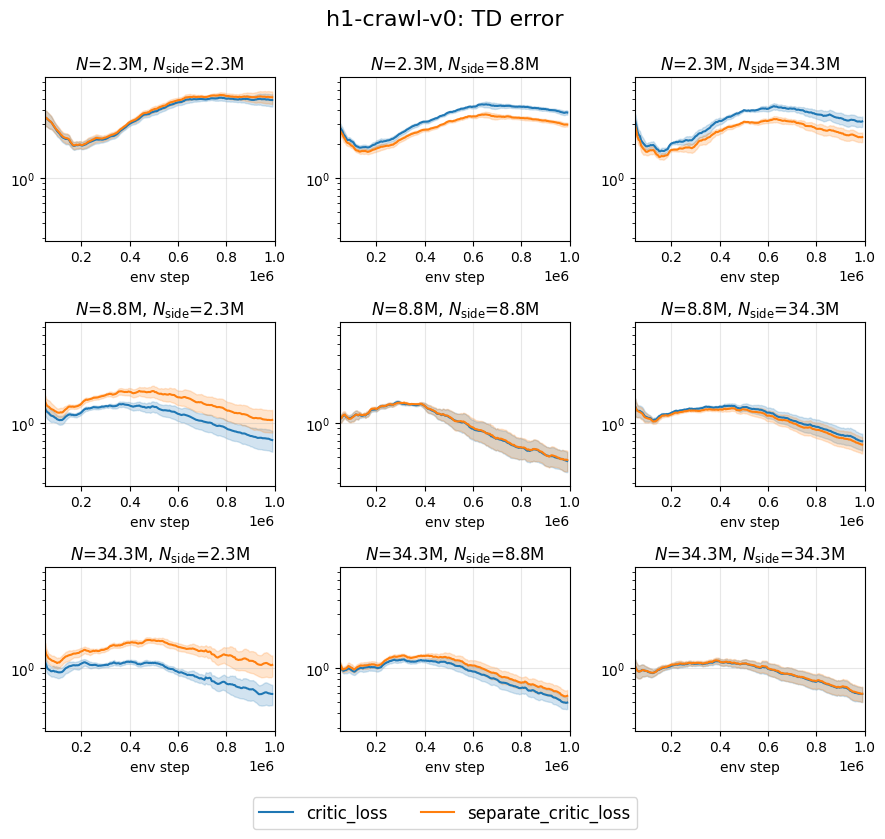

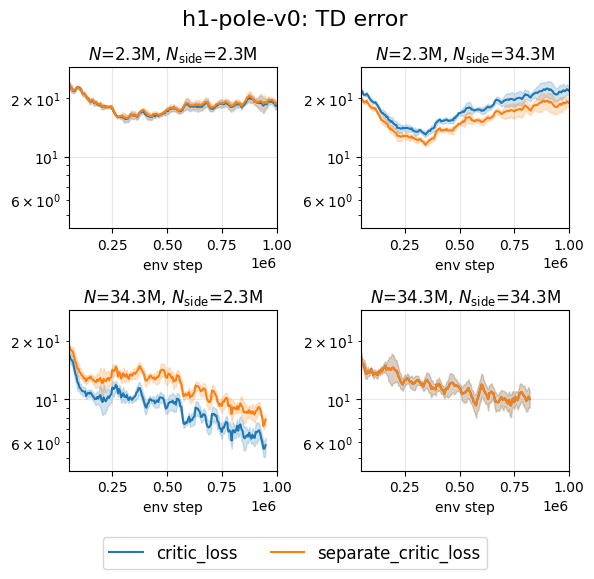

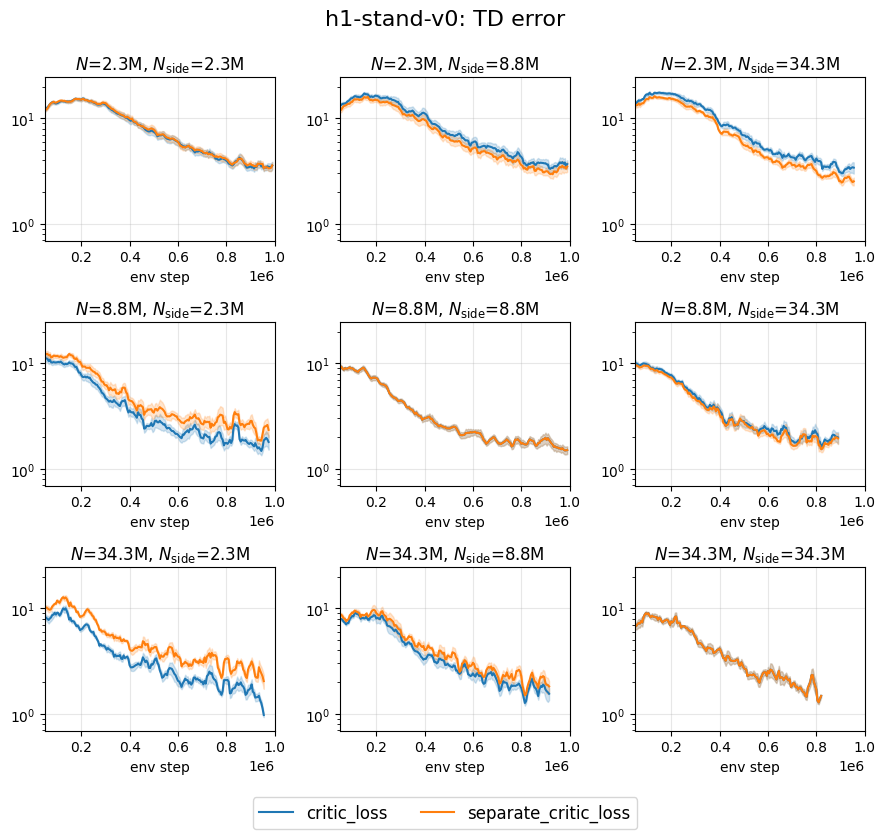

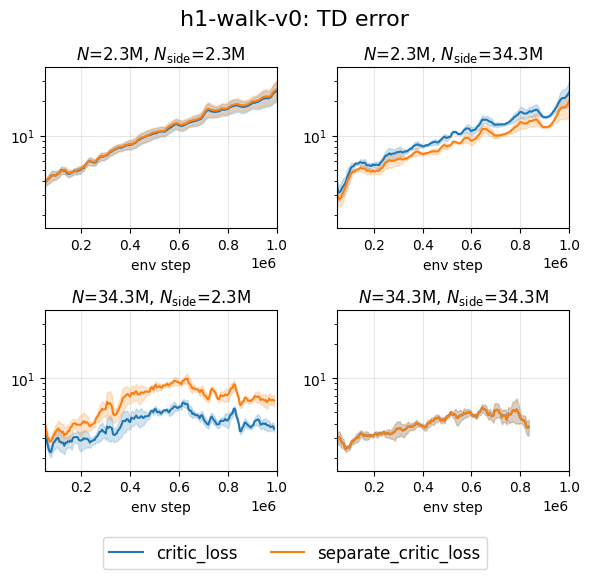

In [21]:
for env, group in df.groupby('env_name'):
    plot_metric_over_training_3d_multiple_metrics(
        group,
        ['critic_loss', 'separate_critic_loss'],
        suptitle=f'{env}: TD error',
        yscale='log',
        **plot_kw,
    )

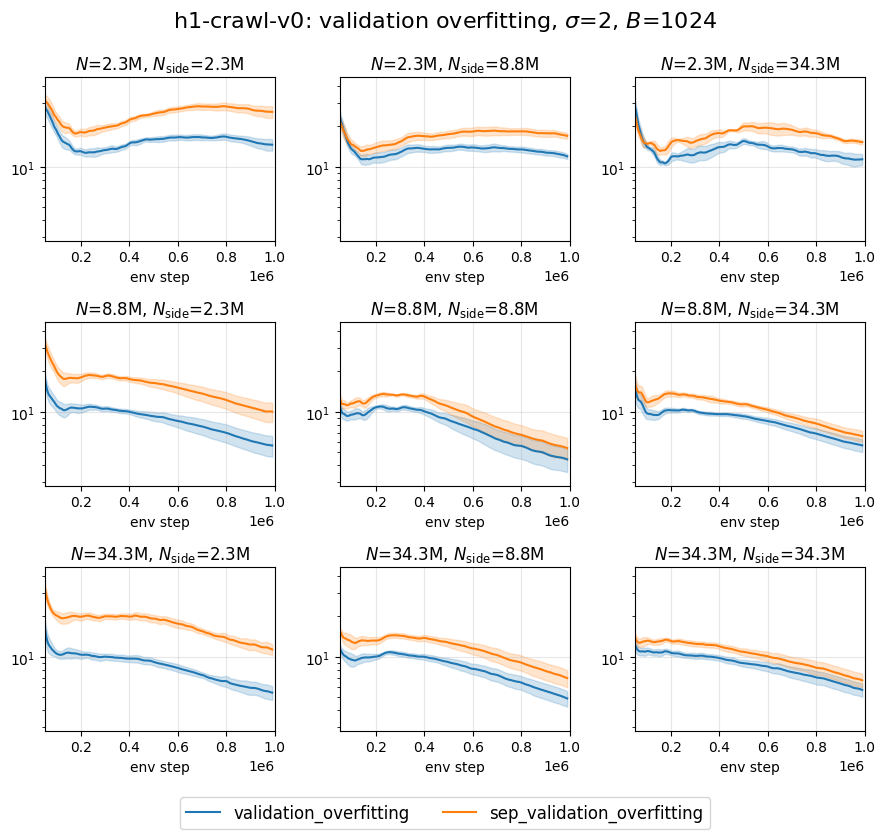

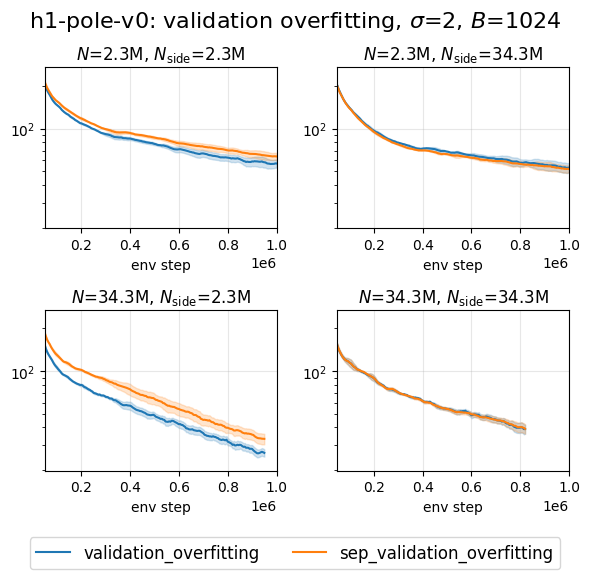

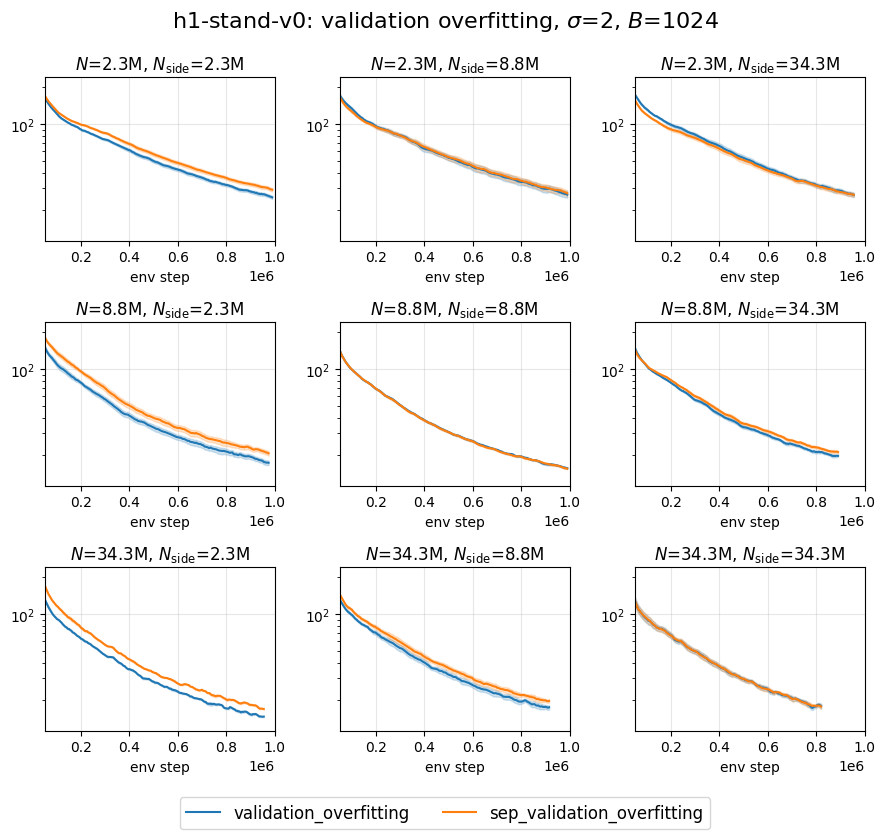

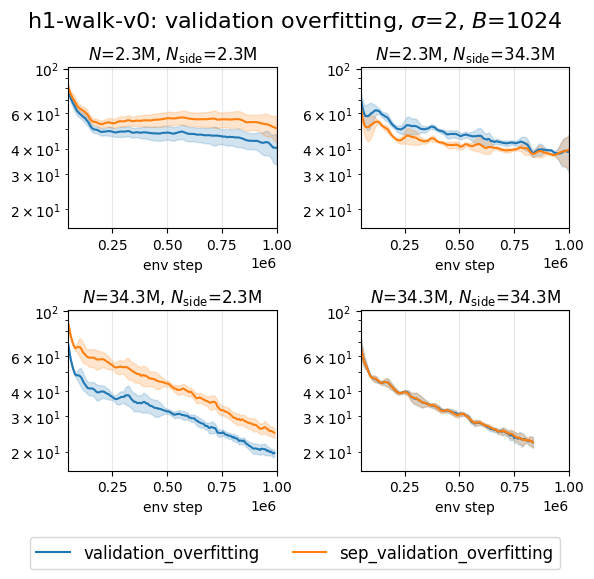

In [10]:
for env, group in df.groupby('env_name'):
    plot_metric_over_training_3d_multiple_metrics(
        group,
        ['validation_overfitting', 'sep_validation_overfitting'],
        suptitle=f'{env}: validation overfitting, $\sigma$=2, $B$=1024',
        yscale='log',
        **plot_kw,
    )

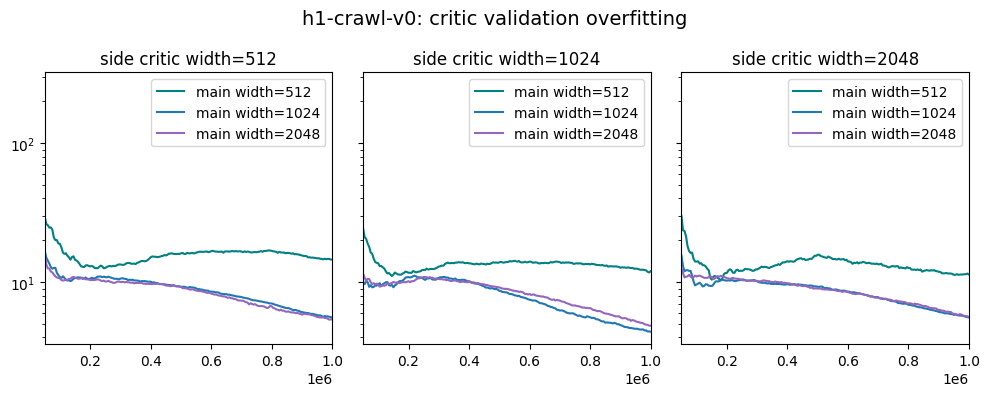

/tmp/ipykernel_1228019/2474216318.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


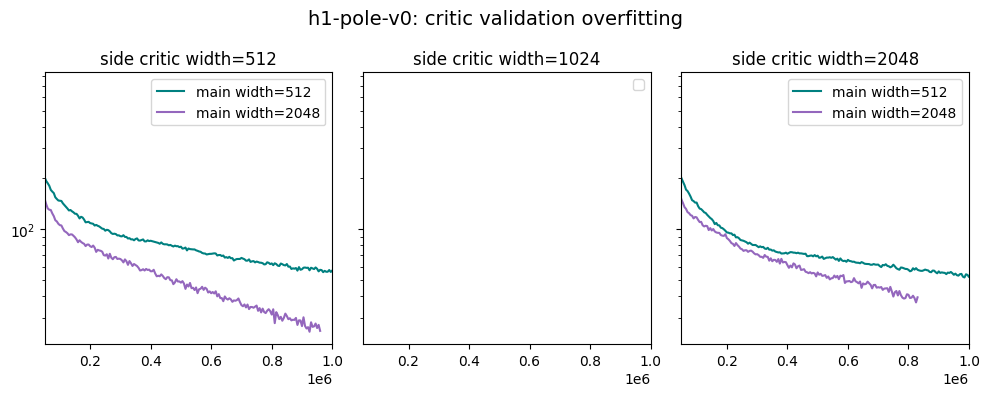

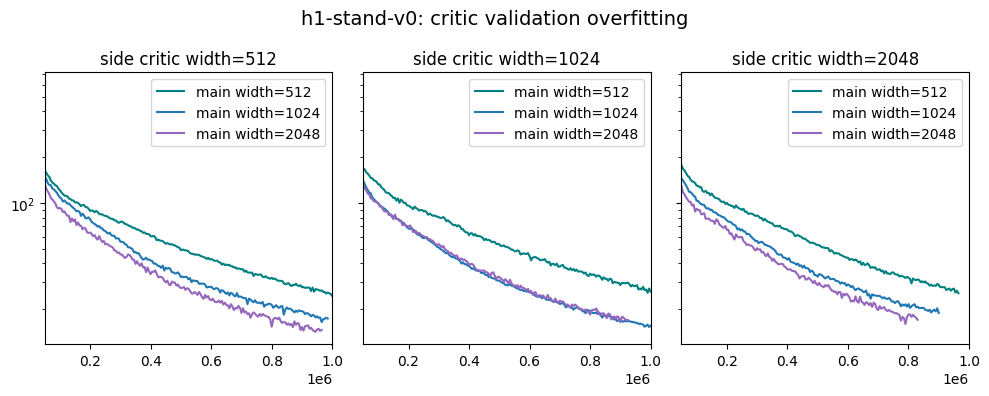

/tmp/ipykernel_1228019/2474216318.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


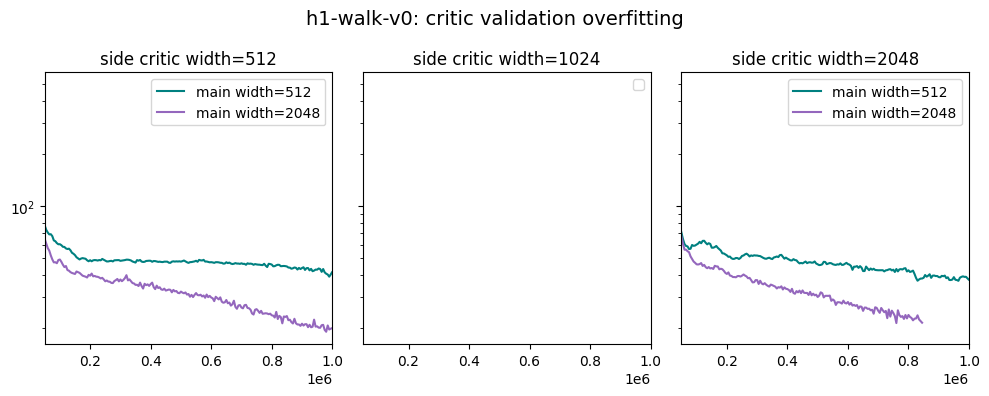

In [9]:
def help(df, metric, suptitle, group_main):
    for env, group in df.groupby('env_name'):
        fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
        # group = group[(group['separate_critic_width'] != 1024) | (group['critic_width'] != 1024)]
        # print(df.query('critic_width==1024 and separate_critic_width==1024'))
        colors = ['teal', 'tab:blue', 'tab:purple']  # , 'tab:red']
        for x, ax in zip([512, 1024, 2048], axes.flatten()):
            subset = group.query(
                f'critic_width=={x}' if group_main else f'separate_critic_width=={x}'
            )
            for i, row in (
                subset.sort_values('separate_critic_width' if group_main else 'critic_width')
                .reset_index()
                .iterrows()
            ):
                # for _, separate_critic_width in sorted(subset['separate_critic_width'].unique()):
                separate_critic_width = row[
                    'separate_critic_width' if group_main else 'critic_width'
                ]
                ax.plot(
                    row['training_step'],
                    row['mean_' + metric],
                    label=f'side width={separate_critic_width}'
                    if group_main
                    else f'main width={separate_critic_width}',
                    color=colors[[512, 1024, 2048].index(separate_critic_width)],
                )
                # ax.fill_between(row['training_step'], row[metric], label=f'side width={separate_critic_width}')
            ax.set_xlim(xmin, xmax)
            ax.set_title(f'main critic width={x}' if group_main else f'side critic width={x}')
            ax.set_yscale('log')
            ax.legend()
        plt.suptitle(f'{env}: {suptitle}', fontsize=14)
        plt.tight_layout()
        plt.show()


help(df, 'validation_overfitting', 'critic validation overfitting', group_main=False)

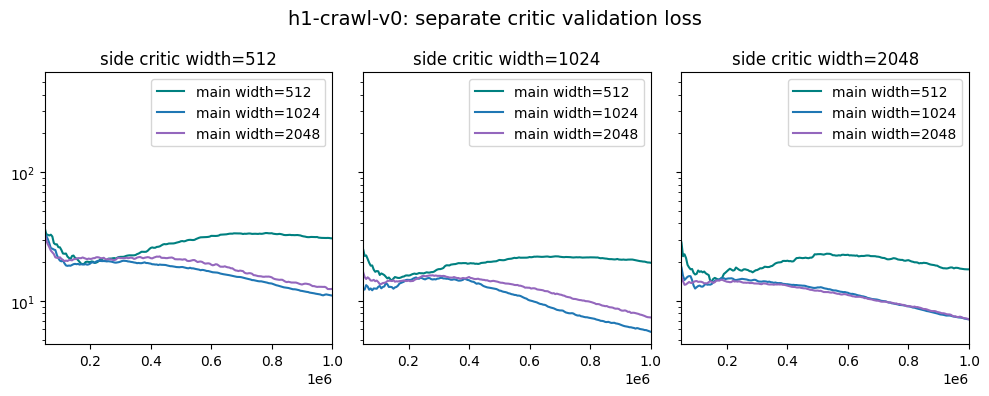

/tmp/ipykernel_1228019/2474216318.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


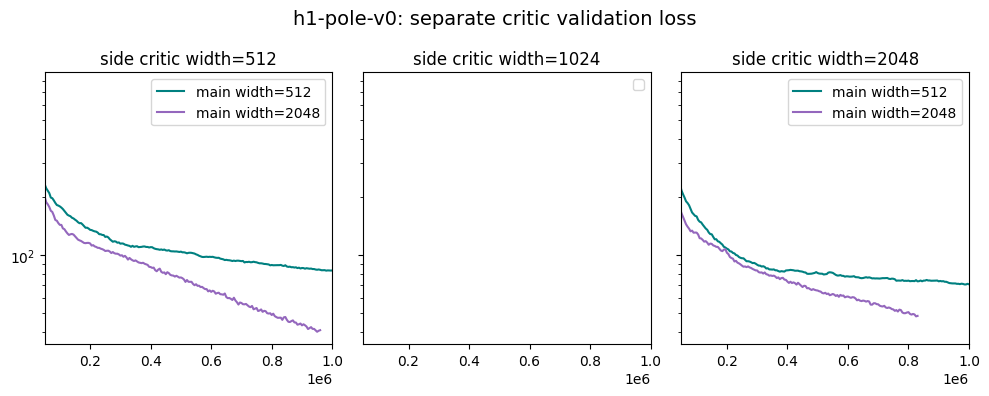

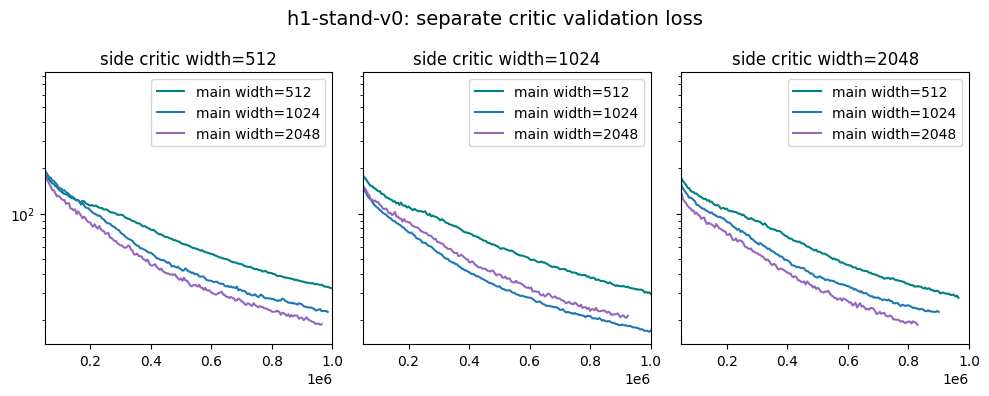

/tmp/ipykernel_1228019/2474216318.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


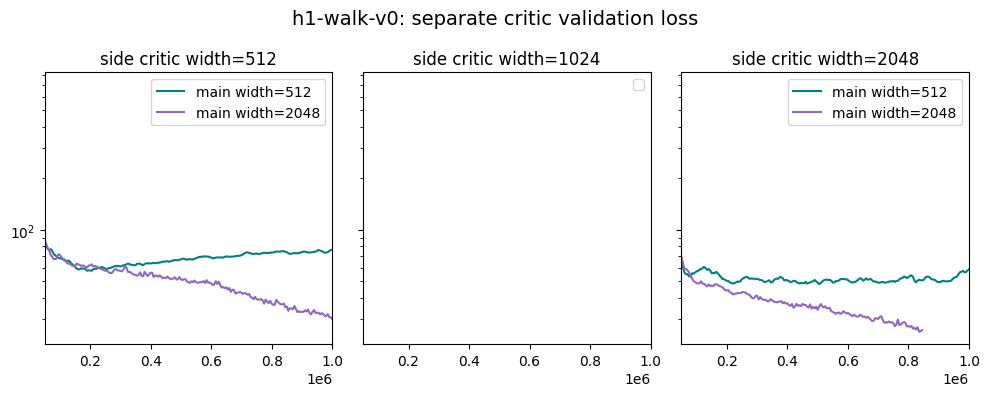

In [10]:
"""
anonymous: plot separate critic validation loss
"""
help(df, 'sep_validation_critic_loss', 'separate critic validation loss', group_main=False)

0     [[651.8135986328125, 642.9429931640625, 602.73...
1     [[564.9671630859375, 630.8533935546875, 581.32...
2     [[566.1212158203125, 616.57275390625, 634.9511...
3     [[345.8145751953125, 334.41864013671875, 347.6...
4     [[349.51165771484375, 357.6617431640625, 363.1...
5     [[345.8758544921875, 351.6214294433594, 352.71...
6     [[650.8661499023438, 670.3258666992188], [757....
7     [[646.5619506835938, 630.7012939453125], [680....
8     [[585.340576171875, 639.4017944335938, 620.546...
9     [[620.9586791992188, 596.2069702148438], [596....
10    [[602.6810302734375, 642.2984619140625, 602.68...
11    [[630.8448486328125, 627.4376220703125, 641.64...
12    [[581.6583862304688, 609.1638793945312, 563.87...
13    [[263.9600524902344, 268.29022216796875, 265.3...
14    [[259.1587219238281, 246.1549072265625, 260.56...
15    [[258.22412109375, 246.0665740966797, 266.6436...
16    [[724.3394775390625, 756.5240478515625], [615....
17    [[681.8045654296875, 694.5882568359375], [

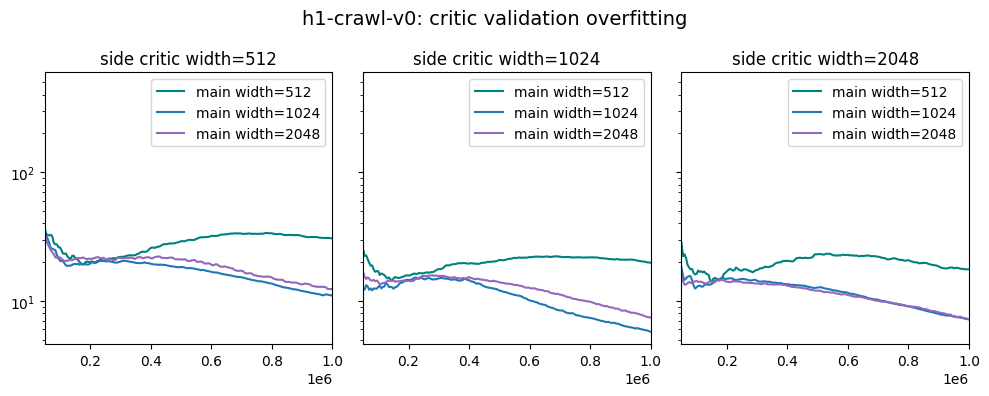

/tmp/ipykernel_1228019/1933621797.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


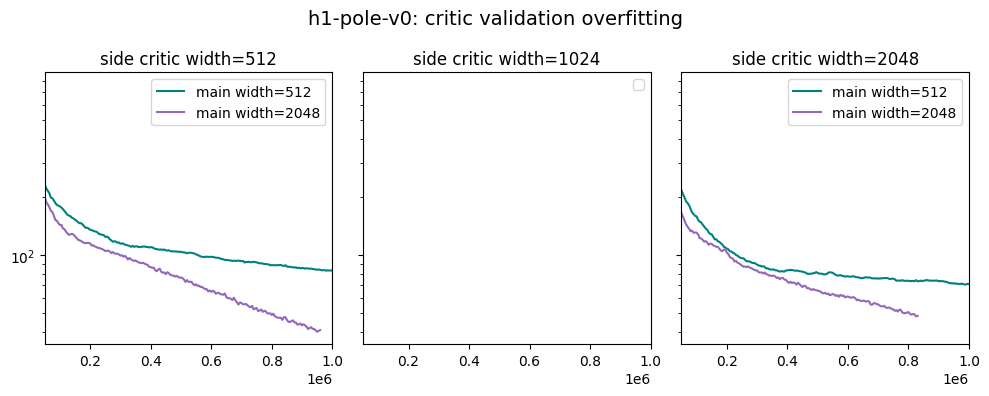

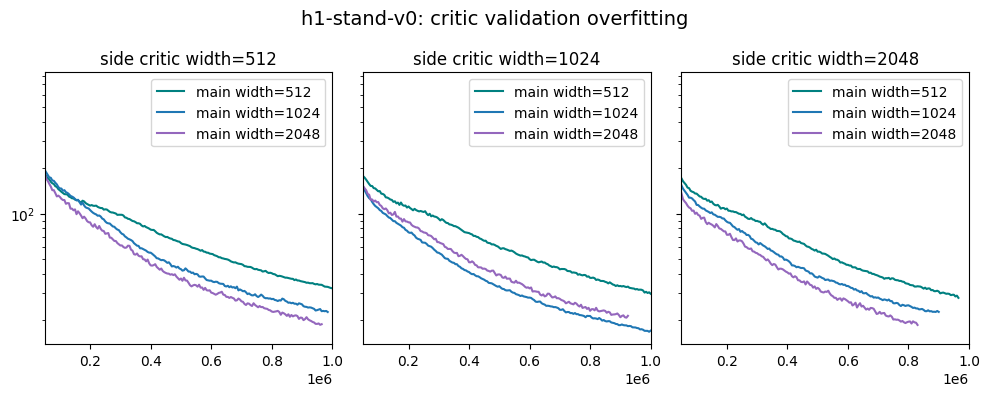

/tmp/ipykernel_1228019/1933621797.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


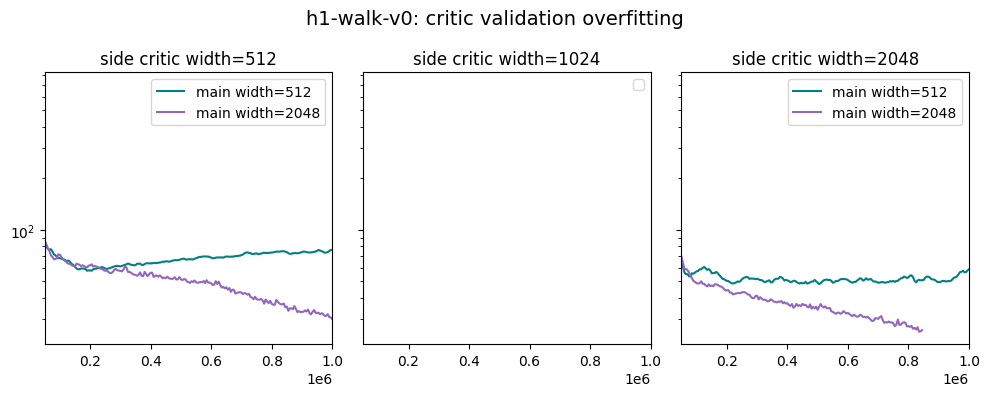

In [ ]:
"""
anonymous: trying to aggregate the plots into one
take last 10% again; remove environment steps
let's also report quantitative evaluation: by how much increasing the side critic
improves loss vs by how much increasing the main critic improves loss


WIP
"""


def aggregate_last_10_percent(df, metric, suptitle, group_main):
    print(df[metric])
    for env, group in df.groupby('env_name'):
        fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
        # group = group[(group['separate_critic_width'] != 1024) | (group['critic_width'] != 1024)]
        # print(df.query('critic_width==1024 and separate_critic_width==1024'))
        colors = ['teal', 'tab:blue', 'tab:purple']  # , 'tab:red']
        metric_name = 'mean_' + metric
        df['summary'] = df[metric_name].apply(
            lambda x: np.nanmean(
                [
                    val
                    for step, val in zip(df['training_step'].values[0], x)
                    if 720000 <= step <= 800000
                ]
            )
        )
        for x, ax in zip([512, 1024, 2048], axes.flatten()):
            subset = group.query(
                f'critic_width=={x}' if group_main else f'separate_critic_width=={x}'
            )
            for i, row in (
                subset.sort_values('separate_critic_width' if group_main else 'critic_width')
                .reset_index()
                .iterrows()
            ):
                # for _, separate_critic_width in sorted(subset['separate_critic_width'].unique()):
                separate_critic_width = row[
                    'separate_critic_width' if group_main else 'critic_width'
                ]
                ax.plot(
                    row['training_step'],
                    row['mean_' + metric],
                    label=f'side width={separate_critic_width}'
                    if group_main
                    else f'main width={separate_critic_width}',
                    color=colors[[512, 1024, 2048].index(separate_critic_width)],
                )
                # ax.fill_between(row['training_step'], row[metric], label=f'side width={separate_critic_width}')
            ax.set_xlim(xmin, xmax)
            ax.set_title(f'main critic width={x}' if group_main else f'side critic width={x}')
            ax.set_yscale('log')
            ax.legend()
        plt.suptitle(f'{env}: {suptitle}', fontsize=14)
        plt.tight_layout()
        plt.show()


aggregate_last_10_percent(
    df, 'sep_validation_critic_loss', 'critic validation overfitting', group_main=False
)

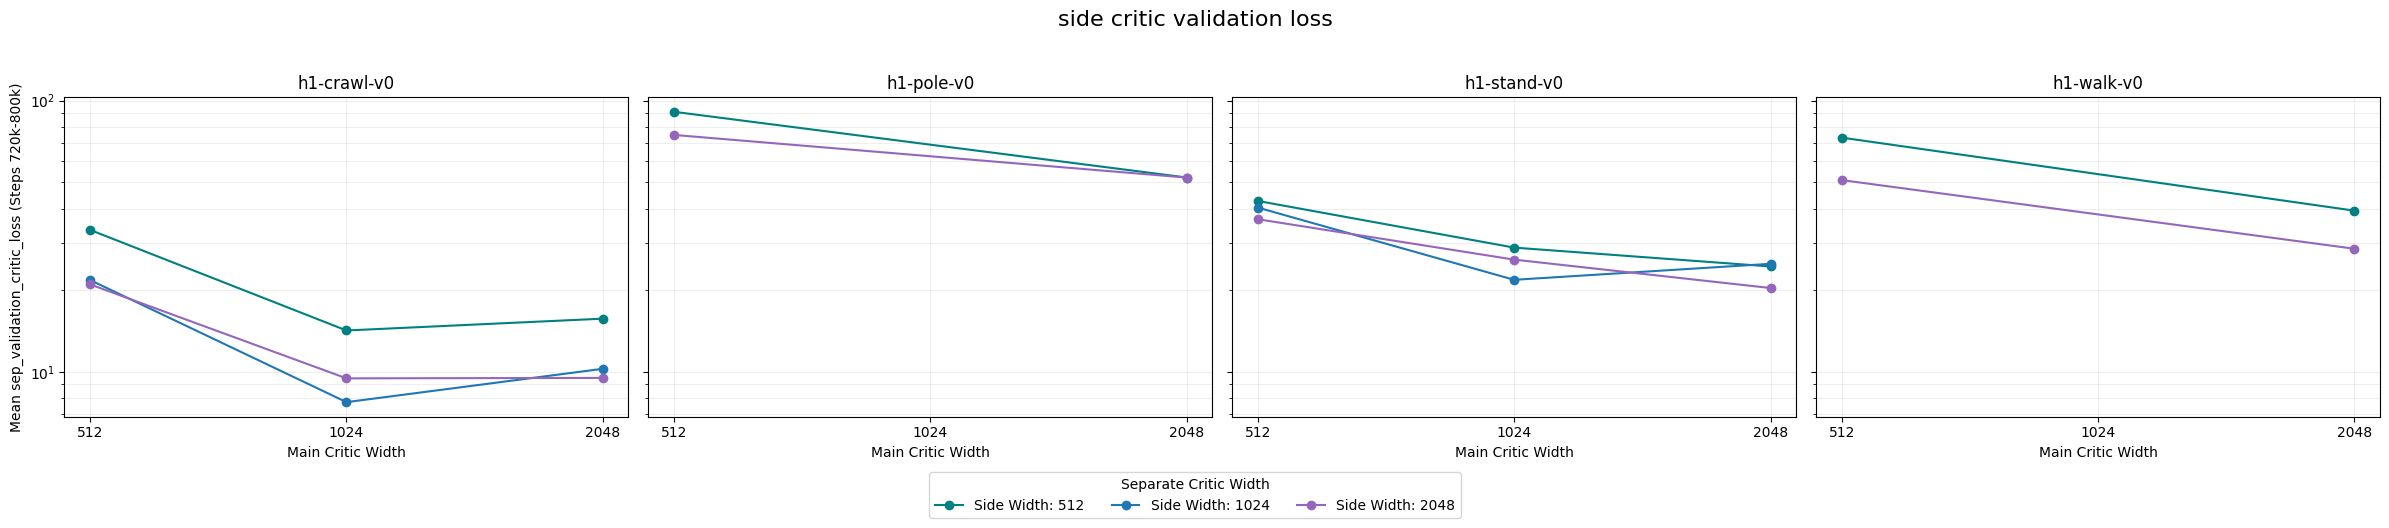

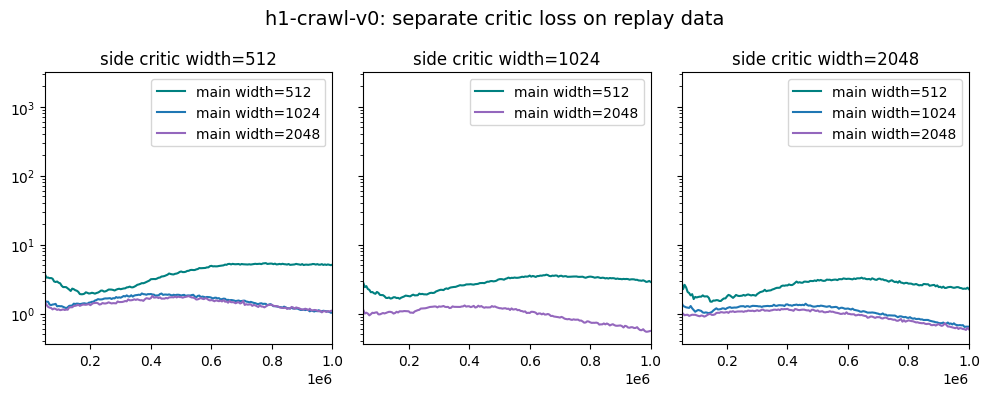

/tmp/ipykernel_822865/1631042847.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


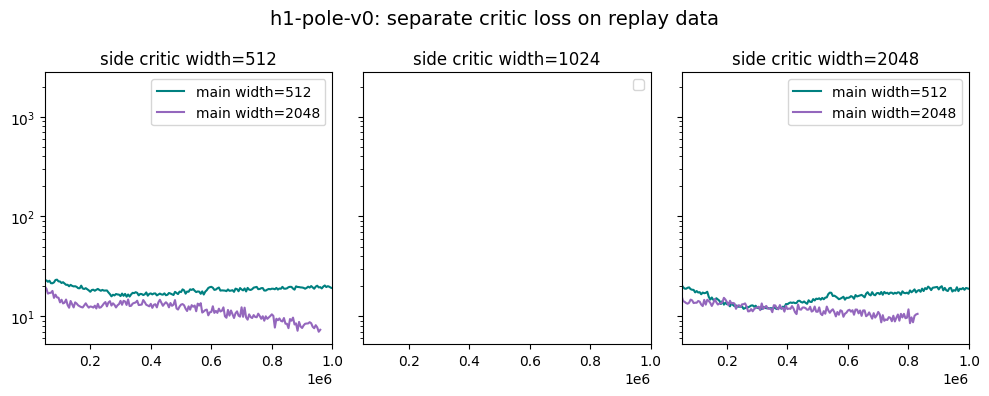

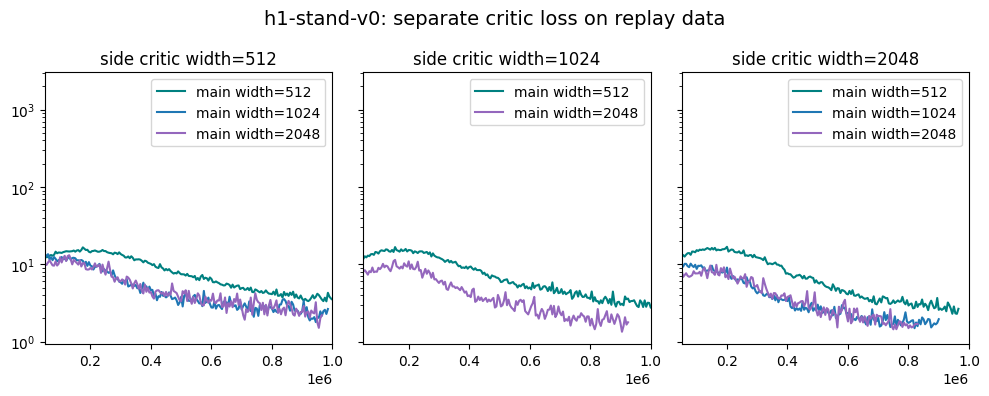

/tmp/ipykernel_822865/1631042847.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


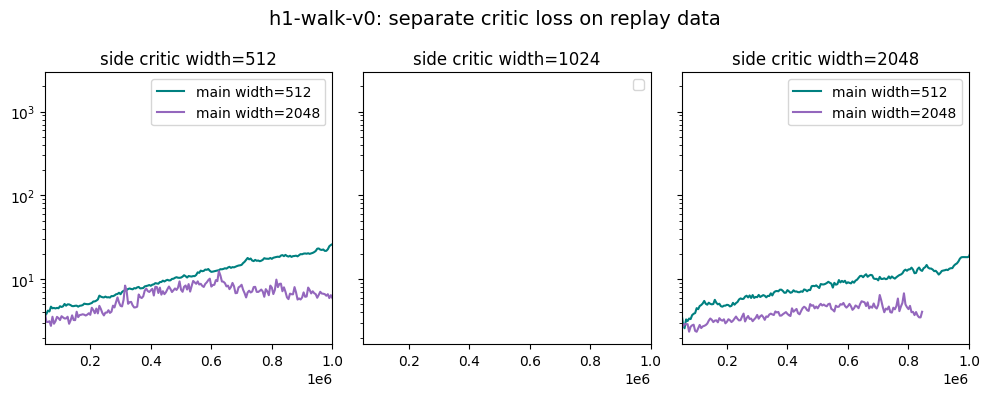

In [26]:
"""
anonymous: plot separate critic training loss
"""
help(df, 'replay_separate_critic_loss', 'separate critic loss on replay data', group_main=False)

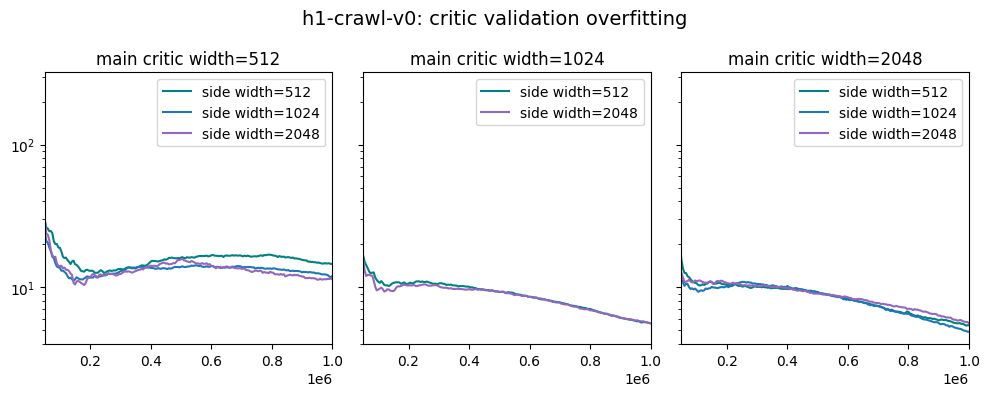

/tmp/ipykernel_465506/1631042847.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


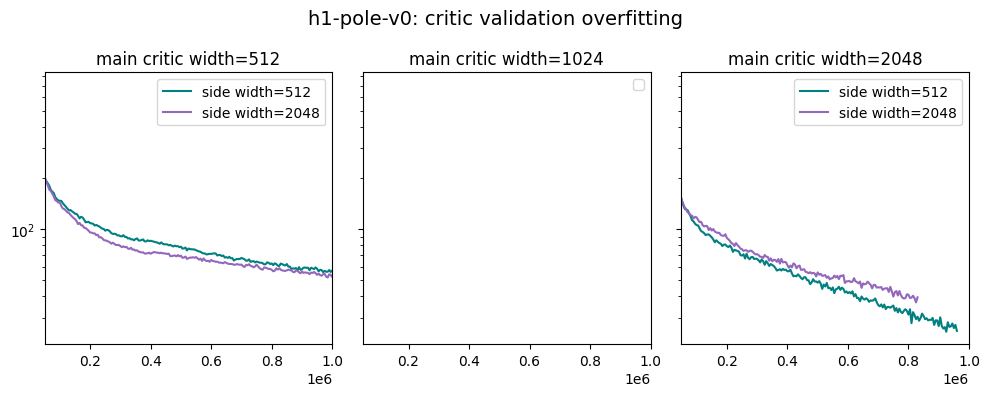

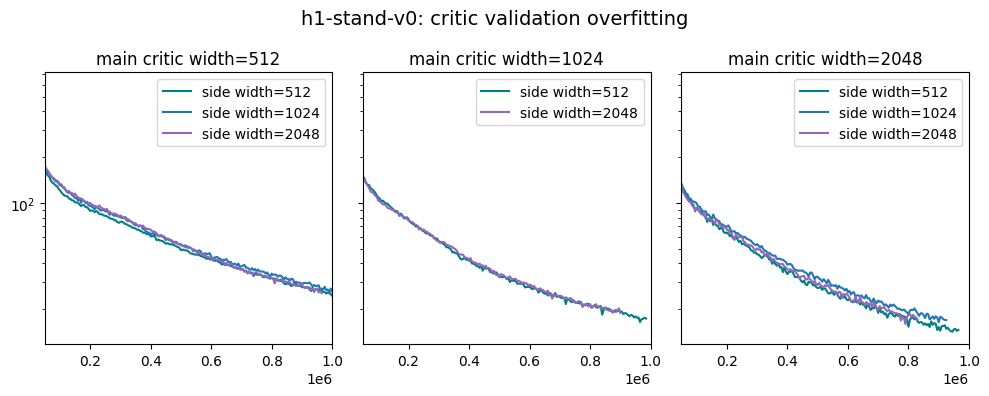

/tmp/ipykernel_465506/1631042847.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


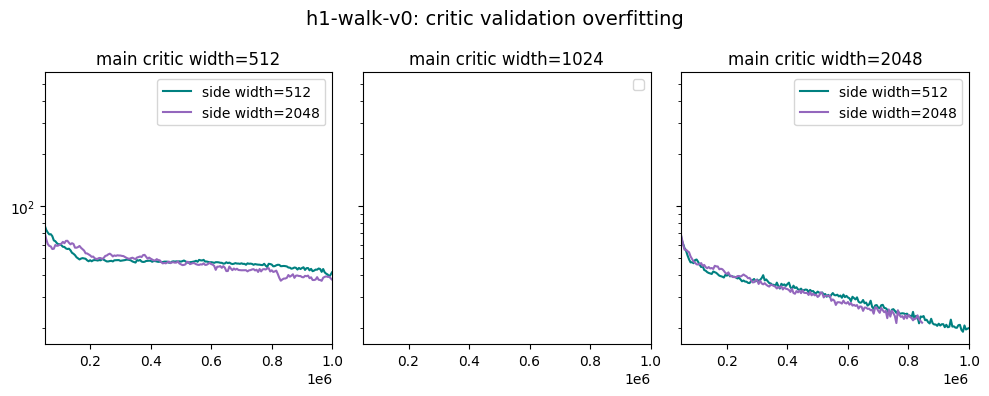

In [13]:
help(df, 'validation_overfitting', 'critic validation overfitting', group_main=True)

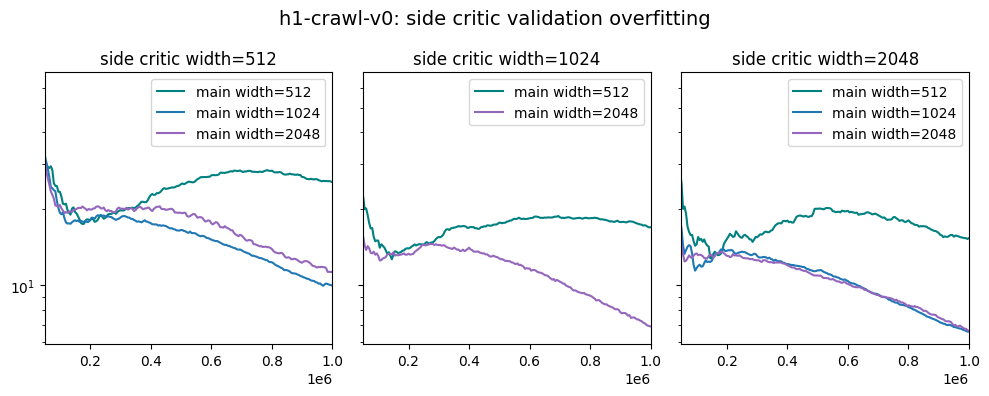

/tmp/ipykernel_465506/1631042847.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


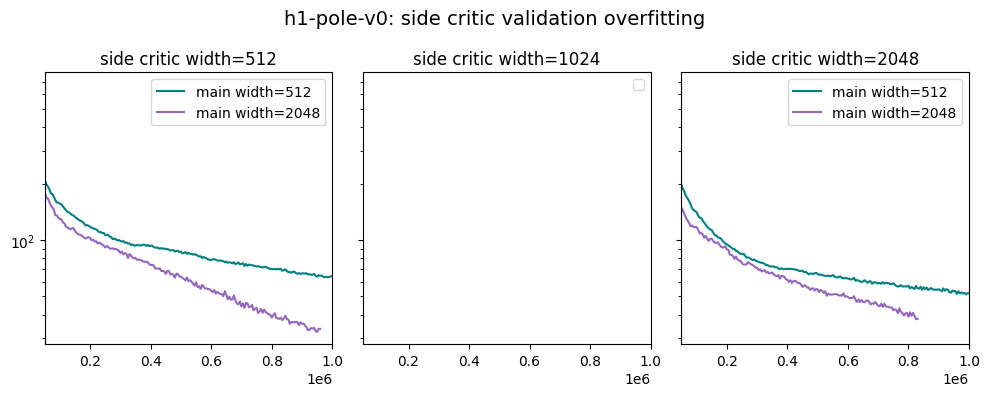

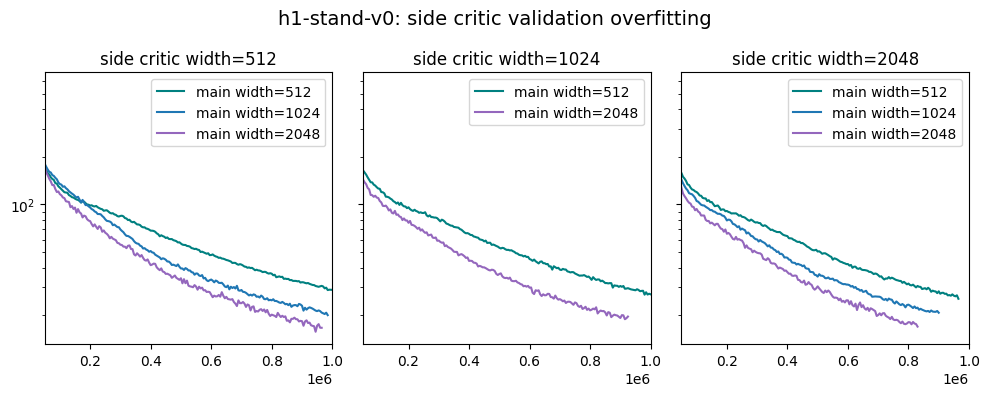

/tmp/ipykernel_465506/1631042847.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


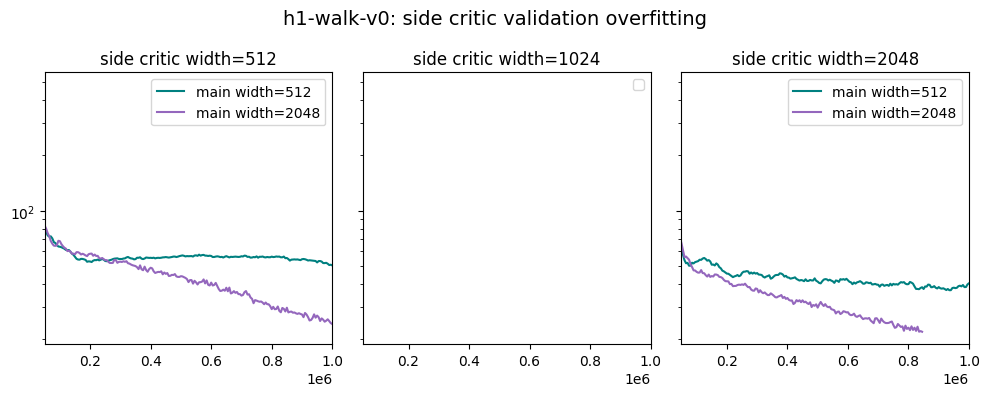

In [14]:
help(df, 'sep_validation_overfitting', 'side critic validation overfitting', group_main=False)

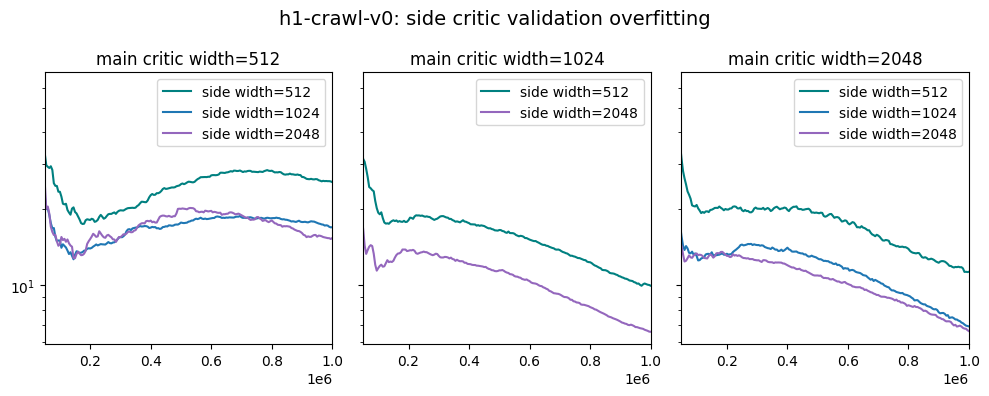

/tmp/ipykernel_465506/1631042847.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


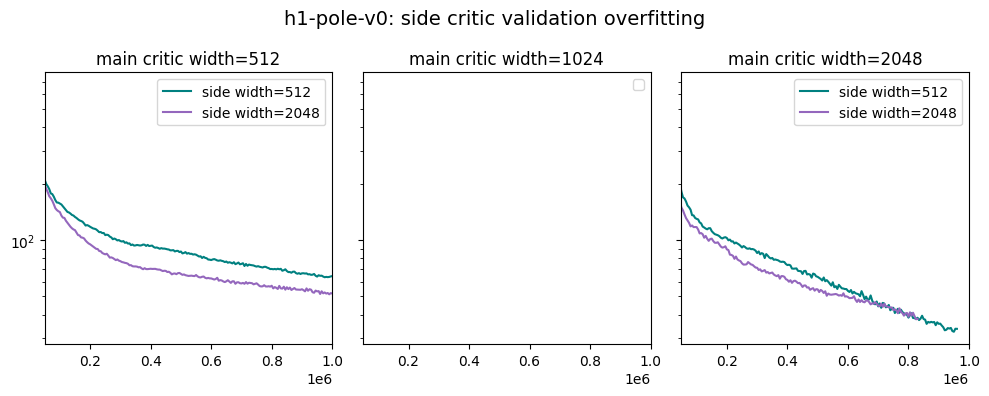

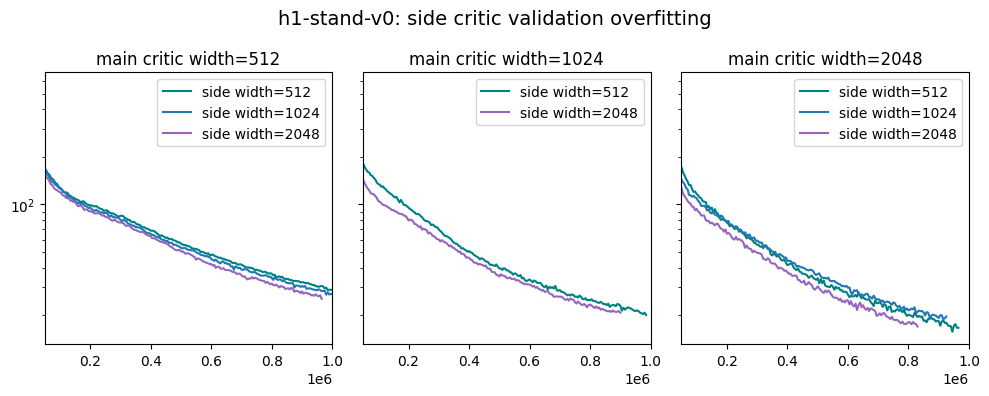

/tmp/ipykernel_465506/1631042847.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


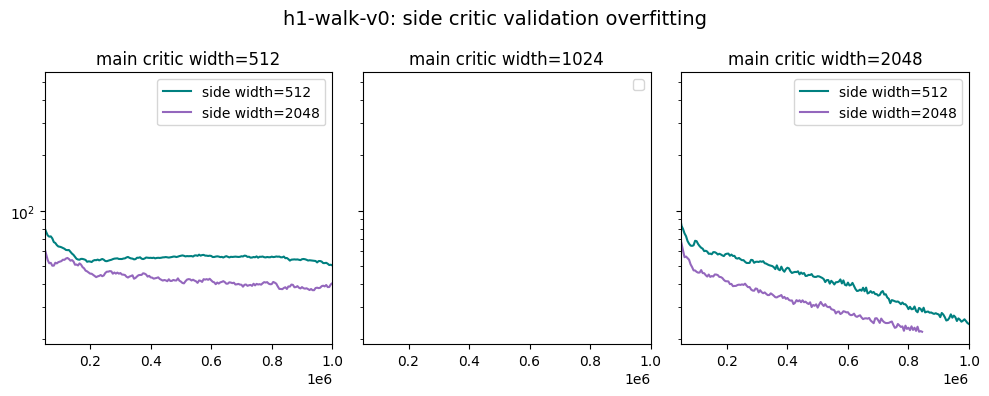

In [15]:
help(df, 'sep_validation_overfitting', 'side critic validation overfitting', group_main=True)

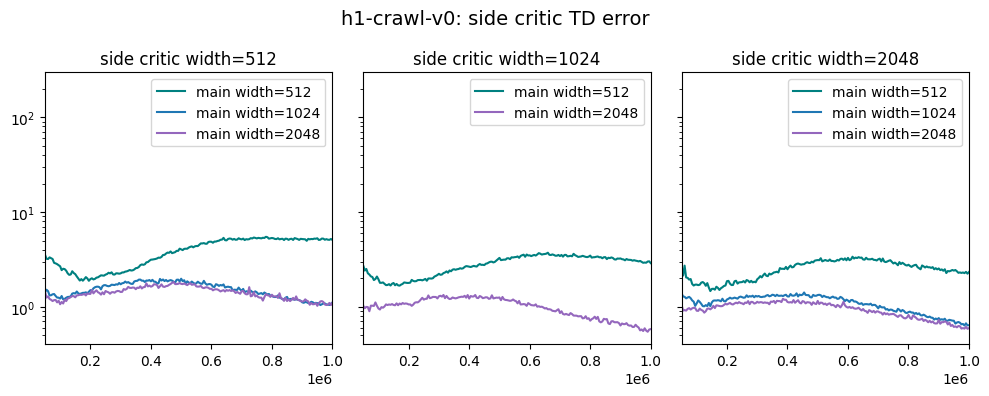

/tmp/ipykernel_465506/1631042847.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


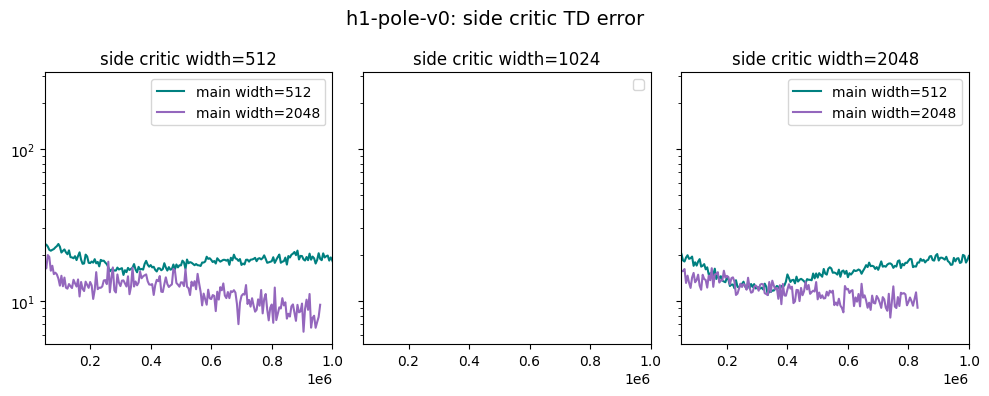

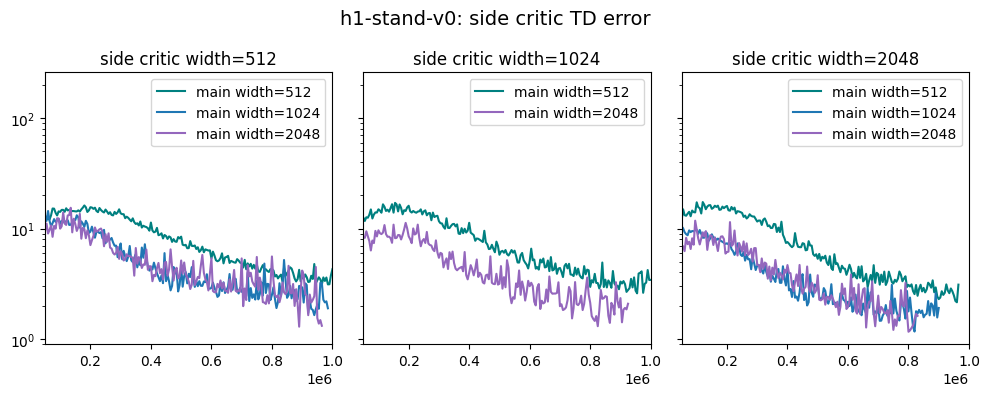

/tmp/ipykernel_465506/1631042847.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


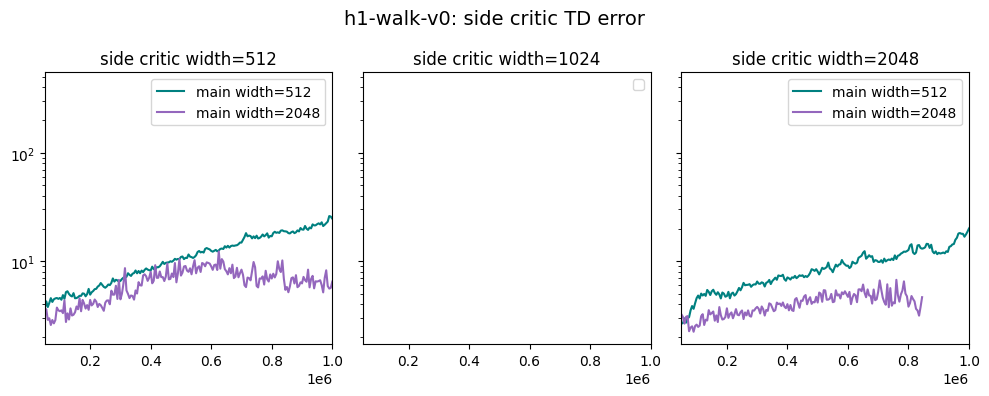

In [16]:
help(df, 'separate_critic_loss', 'side critic TD error', group_main=False)

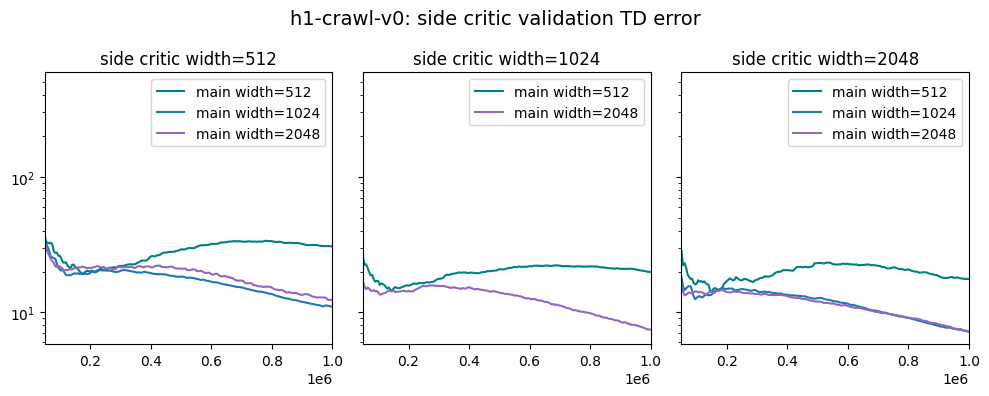

/tmp/ipykernel_465506/1631042847.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


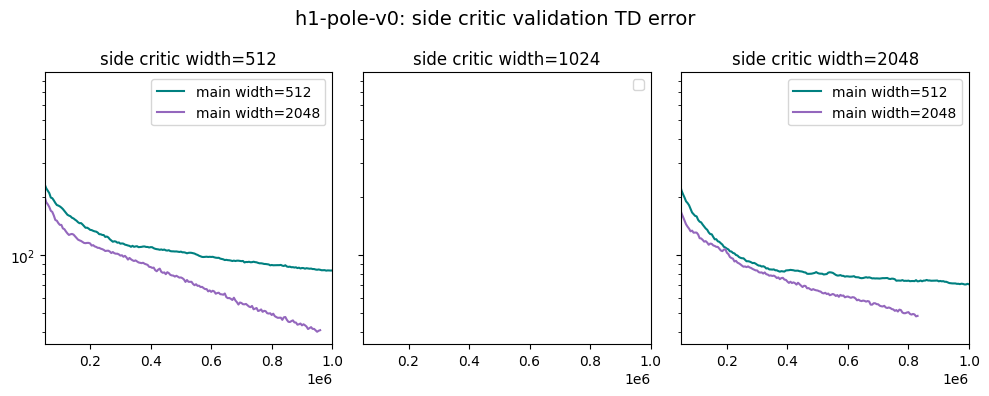

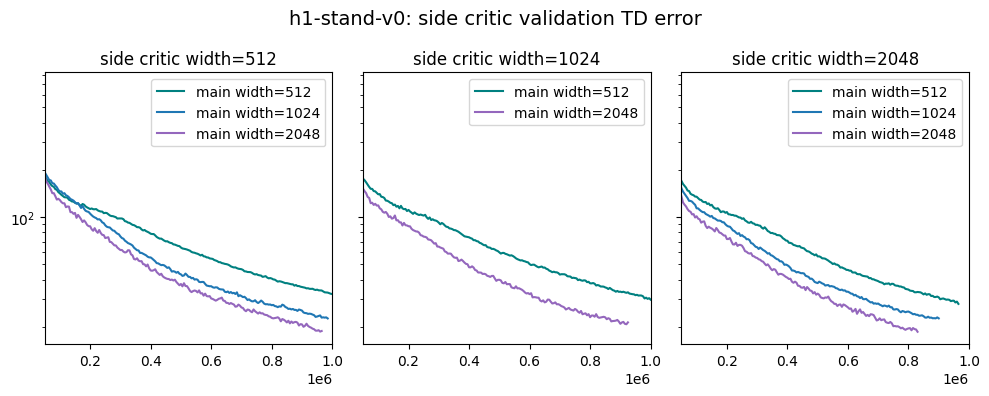

/tmp/ipykernel_465506/1631042847.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


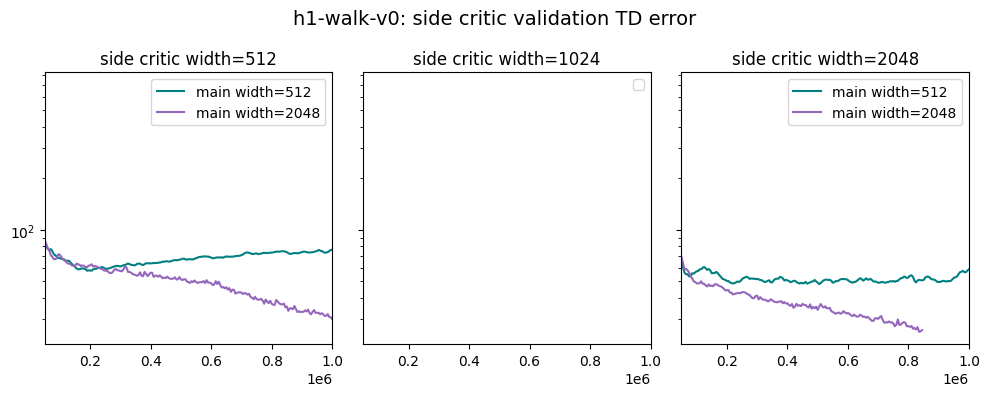

In [21]:
help(df, 'sep_validation_critic_loss', 'side critic validation TD error', group_main=False)